# Trabalho 2

## 4.1

### Imports

In [1]:
import warnings

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn import tree
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.tree import DecisionTreeRegressor, export_text

### Variáveis

In [2]:
ficheiro = "../../ficheiros/Trabalho 2/Dados_Trabalho_TP2.csv"
ficheiro_dummies = "../../ficheiros/Trabalho 2/Dados_Trabalho_dummies_TP2.csv"
colunas_classes_binarias = ['Genero', 'Historico_obesidade_familiar', 'FCCAC', 'Fumador',
                            'MCC']  # Colunas de valores binários, ver 4.1.1.
colunas_numericas = ["Idade", "FCV", "NRP", "CA", "FAF", "TUDE", "IMC"]
colunas_classes = ['Genero', 'Historico_obesidade_familiar', 'FCCAC', 'Fumador', 'MCC']
colunas_classes_multiplos = ["CCER", "CBA", "TRANS"]

%matplotlib inline

skip_graficos = False

# Funções auxiliares

In [3]:
def titulo(texto: str):
    print(f"\033[21;30;44m{texto}\033[0m")


def etiqueta_e_valor(etiqueta: str, valor: str = ""):
    print(f"\033[0;94m{etiqueta}: \033[1;94m{valor}\033[0m")


def texto(texto: str, cor="94"):
    print(f"\033[0;{cor}m{texto}\033[0m")


def undersplit(texto):
    return " ".join(texto.split("_"))


def histograma(
        dados: pd.Series,
        grupos: int = 20,
        kde: bool = True,
        size_x: int = 4,
        size_y: int = 4,
        titulo: str = "",
        etiqueta_x: str = "",
        etiqueta_y: str = "",
        color: str = "skyblue",
        edgecolor: str = "black",
):
    """Gera um histograma de forma isolada.
    
    A dimensão final do gráfico é controlada pela relação entre os valores size_x e size_y.
    """
    hist_fig, hist_axes = plt.subplots(figsize=(size_x, size_y))
    sns.histplot(dados, bins=grupos, kde=kde, color=color, edgecolor=edgecolor)
    hist_axes.set_title(titulo)
    hist_axes.set_xlabel(etiqueta_x)
    hist_axes.set_ylabel(etiqueta_y)
    plt.tight_layout()


def tarte(
        dados: pd.Series,
        size_x: int = 4,
        size_y: int = 4,
        autopct="%.2f%%",
        titulo: str = "",
        **kwargs,
):
    pie_fig, pie_axes = plt.subplots(figsize=(size_x, size_y))
    pie_axes.pie(
        dados,
        autopct=autopct,
        **kwargs
    )
    pie_fig.suptitle(titulo)
    return pie_fig, pie_axes


### Inicializações

In [4]:
warnings.filterwarnings("ignore")  # Desabilitar warnbings.
plt.style.use(
    "style/estilo.mplstyle")  # Garantir que se utiliza um estilo definido centralmente e comum a todos os gráficos.
label_encoder = LabelEncoder()

### 4.1.1

#### Leitura de dados

Como os dados lidos não são em grande quantidade, vamos criar uma cópia do **dataset** para trabalharmos nesta, para poder ter acesso aos "originais" sem ter de os ler novamente do ficheiro.
Por exemplo em alguns dos gráficos, a utilização das *classes* (valores originais) como *etiqueta* é mais elucidativa que usar os valores codificados.  

Na análise ao **dataset** verifica-se que a primeira coluna, identificada como "Unnamed" tem o indíce de cada registo de dados, algo que nos é fornecido pelo **pandas**, e portanto podemos eliminar esta coluna. 
Esta operação estaria incluída nas tarefas do ponto *4.1.4*, mas realizar neste ponto facilita a criação dos gráficos no próximo ponto.

In [5]:
dados_lidos = pd.read_csv(ficheiro)
dados_analise = dados_lidos.copy()
dados_analise.drop(columns=dados_lidos.columns[0], axis=1, inplace=True)

### Dimensão dos dados (lidos)

Os dados lidos incluem 1 coluna com o valor dos indices das linhas, que é removida de imediato.

In [6]:
nr_linhas, nr_colunas = dados_lidos.shape
titulo("Dimensão dos dados")
etiqueta_e_valor("Número de linhas:", nr_linhas)
etiqueta_e_valor("Número de colunas:", nr_colunas)

Dimensão dos dados
Número de linhas:: 2111
Número de colunas:: 18


### Análise do dataset

#### Atributos

Descrição dos atributos, segundo a documentação. 

| Sigla | Descrição                                                         |
|-------|-------------------------------------------------------------------|
| FCCAC | Frequência de Consumo de Comida Altamente Calórica                | 
| FCV   | Frequência de Consumo de Vegetais                                 | 
| NRP   | Número de Refeições Principais                                    |
| CCER  | Consumo de Comida Entre Refeições                                 |
| CA    | Consumo de Água                                                   |
| CBA   | Consumo de Bebidas Alcoólicas                                     |
| MCC   | Monitorização do Consumo Calorias Histórico de Obesidade Familiar | 

#### Informação sobre o dataset

A função ``info()`` apresenta a informação das colunas (atríbutos): Index da coluna, nome (se tiver, quantidade de registos *não nulos* e o tipo de dados de cada um deles.

In [7]:
dados_analise.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2111 entries, 0 to 2110
Data columns (total 17 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Genero                        2111 non-null   object 
 1   Idade                         2111 non-null   float64
 2   Altura                        2111 non-null   float64
 3   Peso                          2111 non-null   float64
 4   Historico_obesidade_familiar  2111 non-null   object 
 5   FCCAC                         2111 non-null   object 
 6   FCV                           2111 non-null   float64
 7   NRP                           2111 non-null   float64
 8   CCER                          2111 non-null   object 
 9   Fumador                       2111 non-null   object 
 10  CA                            2111 non-null   float64
 11  MCC                           2111 non-null   object 
 12  FAF                           2111 non-null   float64
 13  TUD

#### Amostra do dataset

Para uma rápida visualização dos dados, temos as funções ``head(n)`` e ``tail(n)`` que nos dão *n* linhas, por defeito **5**, respetivamente do início ou fim do **dataset**.

In [8]:
dados_analise.head()

Genero  Idade  Altura  Peso Historico_obesidade_familiar FCCAC  FCV  \
0   Feminino   21.0    1.62  64.0                          Sim   Nao  2.0   
1   Feminino   21.0    1.52  56.0                          Sim   Nao  3.0   
2  Masculino   23.0    1.80  77.0                          Sim   Nao  2.0   
3  Masculino   27.0    1.80  87.0                          Nao   Nao  3.0   
4  Masculino   22.0    1.78  89.8                          Nao   Nao  2.0   

   NRP            CCER Fumador   CA  MCC  FAF  TUDE             CBA  \
0  3.0  Ocasionalmente     Nao  2.0  Nao  0.0   1.0             Nao   
1  3.0  Ocasionalmente     Sim  3.0  Sim  3.0   0.0  Ocasionalmente   
2  3.0  Ocasionalmente     Nao  2.0  Nao  2.0   1.0  Frequentemente   
3  3.0  Ocasionalmente     Nao  2.0  Nao  2.0   0.0  Frequentemente   
4  1.0  Ocasionalmente     Nao  2.0  Nao  0.0   0.0  Ocasionalmente   

                  TRANS                 Label  
0  Transportes_Publicos           Peso_Normal  
1  Transportes_Publicos           Peso_Normal  
2  Transportes_Publicos           Peso_Normal  
3             Caminhada   Excesso_Peso_Grau_I  
4  Transportes_Publicos  Excesso_Peso_Grau_II

In [9]:
dados_analise.tail()

Genero      Idade    Altura        Peso Historico_obesidade_familiar  \
2106  Feminino  20.976842  1.710730  131.408528                          Sim   
2107  Feminino  21.982942  1.748584  133.742943                          Sim   
2108  Feminino  22.524036  1.752206  133.689352                          Sim   
2109  Feminino  24.361936  1.739450  133.346641                          Sim   
2110  Feminino  23.664709  1.738836  133.472641                          Sim   

     FCCAC  FCV  NRP            CCER Fumador        CA  MCC       FAF  \
2106   Sim  3.0  3.0  Ocasionalmente     Nao  1.728139  Nao  1.676269   
2107   Sim  3.0  3.0  Ocasionalmente     Nao  2.005130  Nao  1.341390   
2108   Sim  3.0  3.0  Ocasionalmente     Nao  2.054193  Nao  1.414209   
2109   Sim  3.0  3.0  Ocasionalmente     Nao  2.852339  Nao  1.139107   
2110   Sim  3.0  3.0  Ocasionalmente     Nao  2.863513  Nao  1.026452   

          TUDE             CBA                 TRANS              Label  
2106  0.906247  Ocasionalmente  Transportes_Publicos  Obesidade_Mórbida  
2107  0.599270  Ocasionalmente  Transportes_Publicos  Obesidade_Mórbida  
2108  0.646288  Ocasionalmente  Transportes_Publicos  Obesidade_Mórbida  
2109  0.586035  Ocasionalmente  Transportes_Publicos  Obesidade_Mórbida  
2110  0.714137  Ocasionalmente  Transportes_Publicos  Obesidade_Mórbida

#### Descrição do dados do dateset

A função ``describe()`` analisa os dados do **dataset** e retorna um conjunto de estatísticas descritivas.

In [10]:
dados_analise.describe(include="all")

Genero        Idade       Altura         Peso  \
count        2111  2111.000000  2111.000000  2111.000000   
unique          2          NaN          NaN          NaN   
top     Masculino          NaN          NaN          NaN   
freq         1068          NaN          NaN          NaN   
mean          NaN    24.312600     1.701677    86.586058   
std           NaN     6.345968     0.093305    26.191172   
min           NaN    14.000000     1.450000    39.000000   
25%           NaN    19.947192     1.630000    65.473343   
50%           NaN    22.777890     1.700499    83.000000   
75%           NaN    26.000000     1.768464   107.430682   
max           NaN    61.000000     1.980000   173.000000   

       Historico_obesidade_familiar FCCAC          FCV          NRP  \
count                          2111  2111  2111.000000  2111.000000   
unique                            2     2          NaN          NaN   
top                             Sim   Sim          NaN          NaN   
freq                           1726  1866          NaN          NaN   
mean                            NaN   NaN     2.419043     2.685628   
std                             NaN   NaN     0.533927     0.778039   
min                             NaN   NaN     1.000000     1.000000   
25%                             NaN   NaN     2.000000     2.658738   
50%                             NaN   NaN     2.385502     3.000000   
75%                             NaN   NaN     3.000000     3.000000   
max                             NaN   NaN     3.000000     4.000000   

                  CCER Fumador           CA   MCC          FAF         TUDE  \
count             2111    2111  2111.000000  2111  2111.000000  2111.000000   
unique               4       2          NaN     2          NaN          NaN   
top     Ocasionalmente     Nao          NaN   Nao          NaN          NaN   
freq              1765    2067          NaN  2015          NaN          NaN   
mean               NaN     NaN     2.008011   NaN     1.010298     0.657866   
std                NaN     NaN     0.612953   NaN     0.850592     0.608927   
min                NaN     NaN     1.000000   NaN     0.000000     0.000000   
25%                NaN     NaN     1.584812   NaN     0.124505     0.000000   
50%                NaN     NaN     2.000000   NaN     1.000000     0.625350   
75%                NaN     NaN     2.477420   NaN     1.666678     1.000000   
max                NaN     NaN     3.000000   NaN     3.000000     2.000000   

                   CBA                 TRANS               Label  
count             2111                  2111                2111  
unique               4                     5                   9  
top     Ocasionalmente  Transportes_Publicos  Obesidade_Moderada  
freq              1401                  1580                 370  
mean               NaN                   NaN                 NaN  
std                NaN                   NaN                 NaN  
min                NaN                   NaN                 NaN  
25%                NaN                   NaN                 NaN  
50%                NaN                   NaN                 NaN  
75%                NaN                   NaN                 NaN  
max                NaN                   NaN                 NaN

### Identificar as classes dos atributos

Os atributos numéricos serão trabalhados mais adiante, quando fizermos a sua **normalização**. Para já vamos verificar as classes existentes para decidir qual a melhor estratégia para os preparar para a utilização nos vários métodos que vamos utilizar.

#### Genero

In [11]:
titulo("Classes da coluna \033[1mGenero\033[0m")
for classe in dados_analise['Genero'].unique():
    texto(classe)

Classes da coluna Genero
Feminino
Masculino


#### Historico_obesidade_familiar

In [12]:
titulo("Classes da coluna \033[1mHistorico_obesidade_familiar\033[0m")
for classe in dados_analise['Historico_obesidade_familiar'].unique():
    texto(classe)

Classes da coluna Historico_obesidade_familiar
Sim
Nao


#### FCCAC

In [13]:
titulo("Classes da coluna \033[1mFCCAC\033[0m")
for classe in dados_analise['FCCAC'].unique():
    texto(classe)

Classes da coluna FCCAC
Nao
Sim


#### CCER

In [14]:
titulo("Classes da coluna \033[1mCCER\033[0m")
for classe in dados_analise['CCER'].unique():
    texto(classe)

Classes da coluna CCER
Ocasionalmente
Frequentemente
Sempre
Não


#### Fumador

In [15]:
titulo("Classes da coluna \033[1mFumador\033[0m")
for classe in dados_analise['Fumador'].unique():
    texto(classe)

Classes da coluna Fumador
Nao
Sim


### MCC

In [16]:
titulo("Classes da coluna \033[1mMCC\033[0m")
for classe in dados_analise['MCC'].unique():
    texto(classe)

Classes da coluna MCC
Nao
Sim


#### CBA

In [17]:
titulo("Classes da coluna \033[1mCBA\033[0m")
for classe in dados_analise['CBA'].unique():
    texto(classe)

Classes da coluna CBA
Nao
Ocasionalmente
Frequentemente
Sempre


#### TRANS

In [18]:
titulo("Classes da coluna \033[1mTRANS\033[0m")
for classe in dados_analise['TRANS'].unique():
    texto(classe)

Classes da coluna TRANS
Transportes_Publicos
Caminhada
Automovel
Mota
Bicicleta


#### Label

In [19]:
titulo("Classes da coluna \033[1mLabel\033[0m")
for classe in dados_analise['Label'].unique():
    texto(classe)

Classes da coluna Label
Peso_Normal
Excesso_Peso_Grau_I
Excesso_Peso_Grau_II
Obesidade_Moderada
Magreza_Grau_I
Obesidade_Severa
Magreza_Grau_II
Magreza_Grau_III
Obesidade_Mórbida


### 4.1.2



#### Derivar atributo (IMC)

Depois de criar o novo atributo, podemos usar qualquer uma das funções que foram utilizadas para analisar o **dataset**, neste caso tratando-se de valores numéricos consideramos que a que a mais útil é a ``describe()``.

Podemos também remover as colunas utilizadas para este cálculo uma vez que não vão ser necessárias.

Faz sentido alguma limpeza do **Dataset** neste momento, pois vai facilitar o nosso trabalho.

In [20]:
dados_analise['IMC'] = dados_analise['Peso'] / (dados_analise['Altura'] * dados_analise['Altura'])
dados_analise.drop(columns=['Peso', 'Altura'], inplace=True)

#### Rever o **dataset** após as alterações

In [21]:
dados_analise.describe(include="all")

Genero        Idade Historico_obesidade_familiar FCCAC  \
count        2111  2111.000000                         2111  2111   
unique          2          NaN                            2     2   
top     Masculino          NaN                          Sim   Sim   
freq         1068          NaN                         1726  1866   
mean          NaN    24.312600                          NaN   NaN   
std           NaN     6.345968                          NaN   NaN   
min           NaN    14.000000                          NaN   NaN   
25%           NaN    19.947192                          NaN   NaN   
50%           NaN    22.777890                          NaN   NaN   
75%           NaN    26.000000                          NaN   NaN   
max           NaN    61.000000                          NaN   NaN   

                FCV          NRP            CCER Fumador           CA   MCC  \
count   2111.000000  2111.000000            2111    2111  2111.000000  2111   
unique          NaN          NaN               4       2          NaN     2   
top             NaN          NaN  Ocasionalmente     Nao          NaN   Nao   
freq            NaN          NaN            1765    2067          NaN  2015   
mean       2.419043     2.685628             NaN     NaN     2.008011   NaN   
std        0.533927     0.778039             NaN     NaN     0.612953   NaN   
min        1.000000     1.000000             NaN     NaN     1.000000   NaN   
25%        2.000000     2.658738             NaN     NaN     1.584812   NaN   
50%        2.385502     3.000000             NaN     NaN     2.000000   NaN   
75%        3.000000     3.000000             NaN     NaN     2.477420   NaN   
max        3.000000     4.000000             NaN     NaN     3.000000   NaN   

                FAF         TUDE             CBA                 TRANS  \
count   2111.000000  2111.000000            2111                  2111   
unique          NaN          NaN               4                     5   
top             NaN          NaN  Ocasionalmente  Transportes_Publicos   
freq            NaN          NaN            1401                  1580   
mean       1.010298     0.657866             NaN                   NaN   
std        0.850592     0.608927             NaN                   NaN   
min        0.000000     0.000000             NaN                   NaN   
25%        0.124505     0.000000             NaN                   NaN   
50%        1.000000     0.625350             NaN                   NaN   
75%        1.666678     1.000000             NaN                   NaN   
max        3.000000     2.000000             NaN                   NaN   

                     Label          IMC  
count                 2111  2111.000000  
unique                   9          NaN  
top     Obesidade_Moderada          NaN  
freq                   370          NaN  
mean                   NaN    29.700159  
std                    NaN     8.011337  
min                    NaN    12.998685  
25%                    NaN    24.325802  
50%                    NaN    28.719089  
75%                    NaN    36.016501  
max                    NaN    50.811753

Finalmente, usamos novamente a função ``info()`` para confirmar as *series* com que vamos trabalhar de seguida. 

In [22]:
dados_analise.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2111 entries, 0 to 2110
Data columns (total 16 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Genero                        2111 non-null   object 
 1   Idade                         2111 non-null   float64
 2   Historico_obesidade_familiar  2111 non-null   object 
 3   FCCAC                         2111 non-null   object 
 4   FCV                           2111 non-null   float64
 5   NRP                           2111 non-null   float64
 6   CCER                          2111 non-null   object 
 7   Fumador                       2111 non-null   object 
 8   CA                            2111 non-null   float64
 9   MCC                           2111 non-null   object 
 10  FAF                           2111 non-null   float64
 11  TUDE                          2111 non-null   float64
 12  CBA                           2111 non-null   object 
 13  TRA

### 4.1.3 Analisar os atributos do conjunto de dados mais significativos, usando gráficos, ...


#### Histogramas

Com estes gráficos podemos ver a distribuição dos valores por "segmentos" de valores.

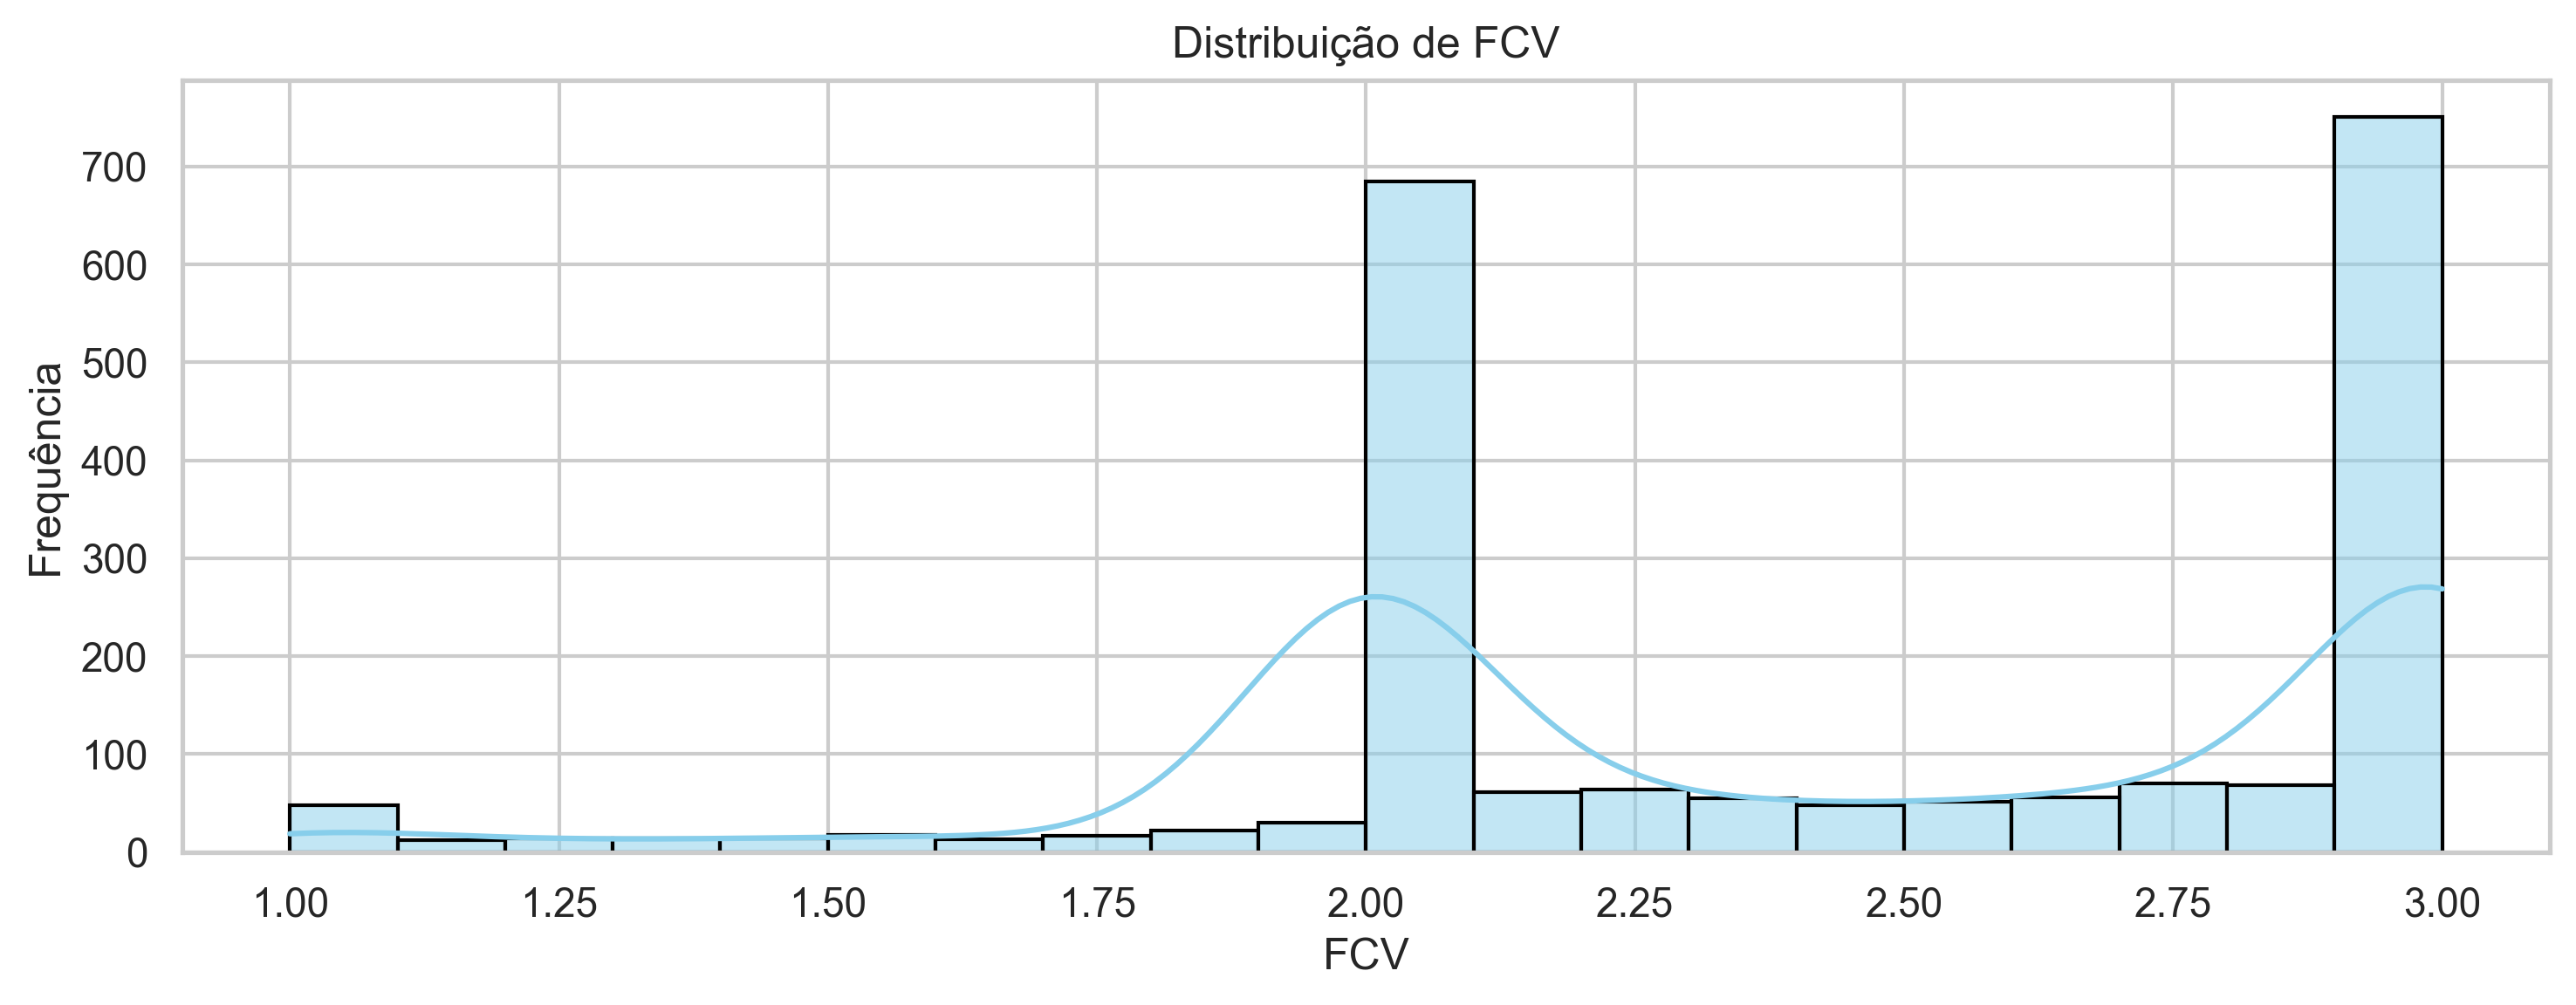

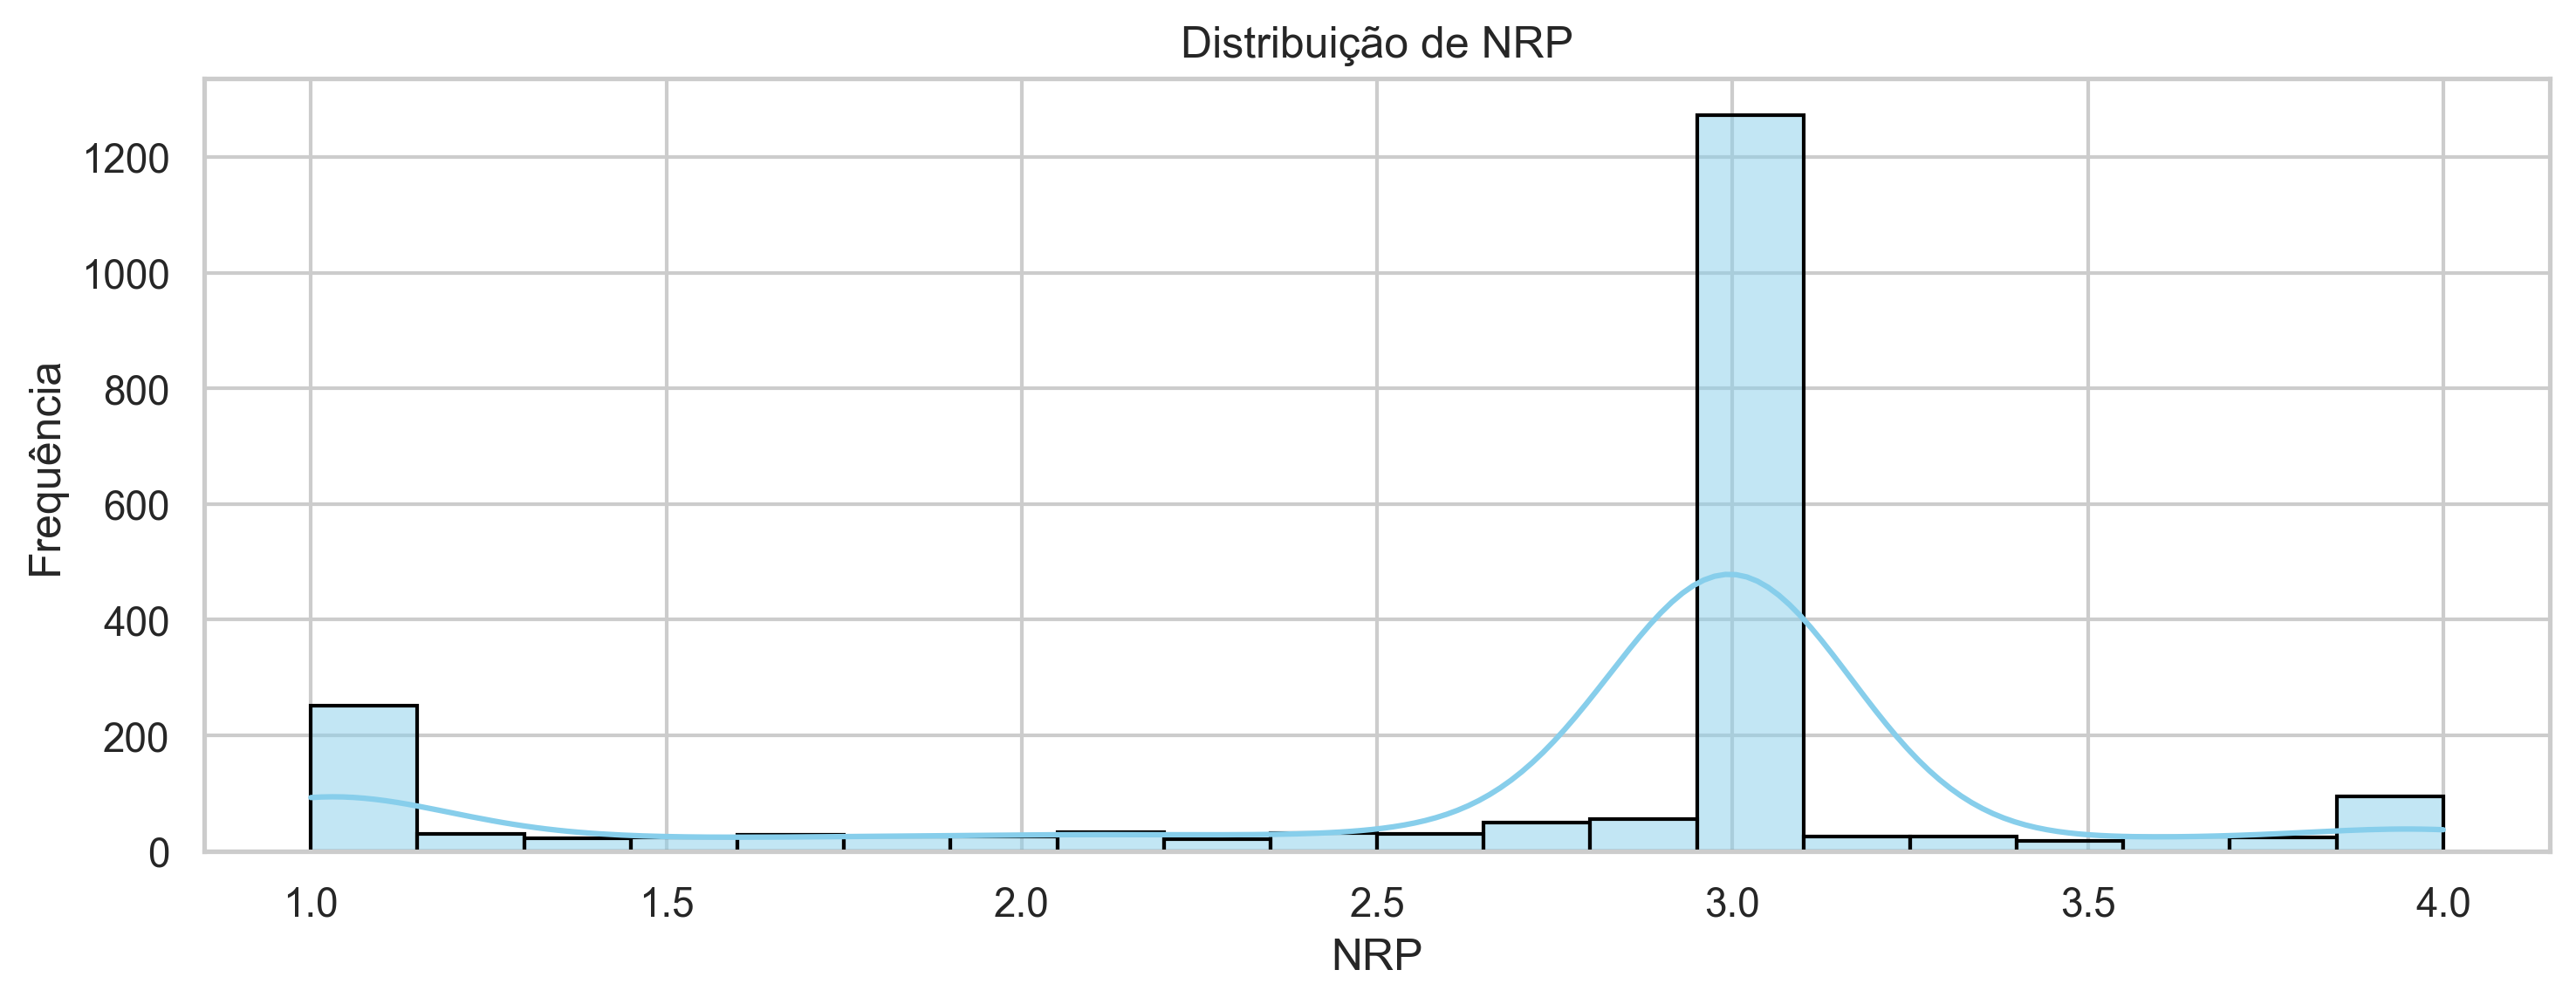

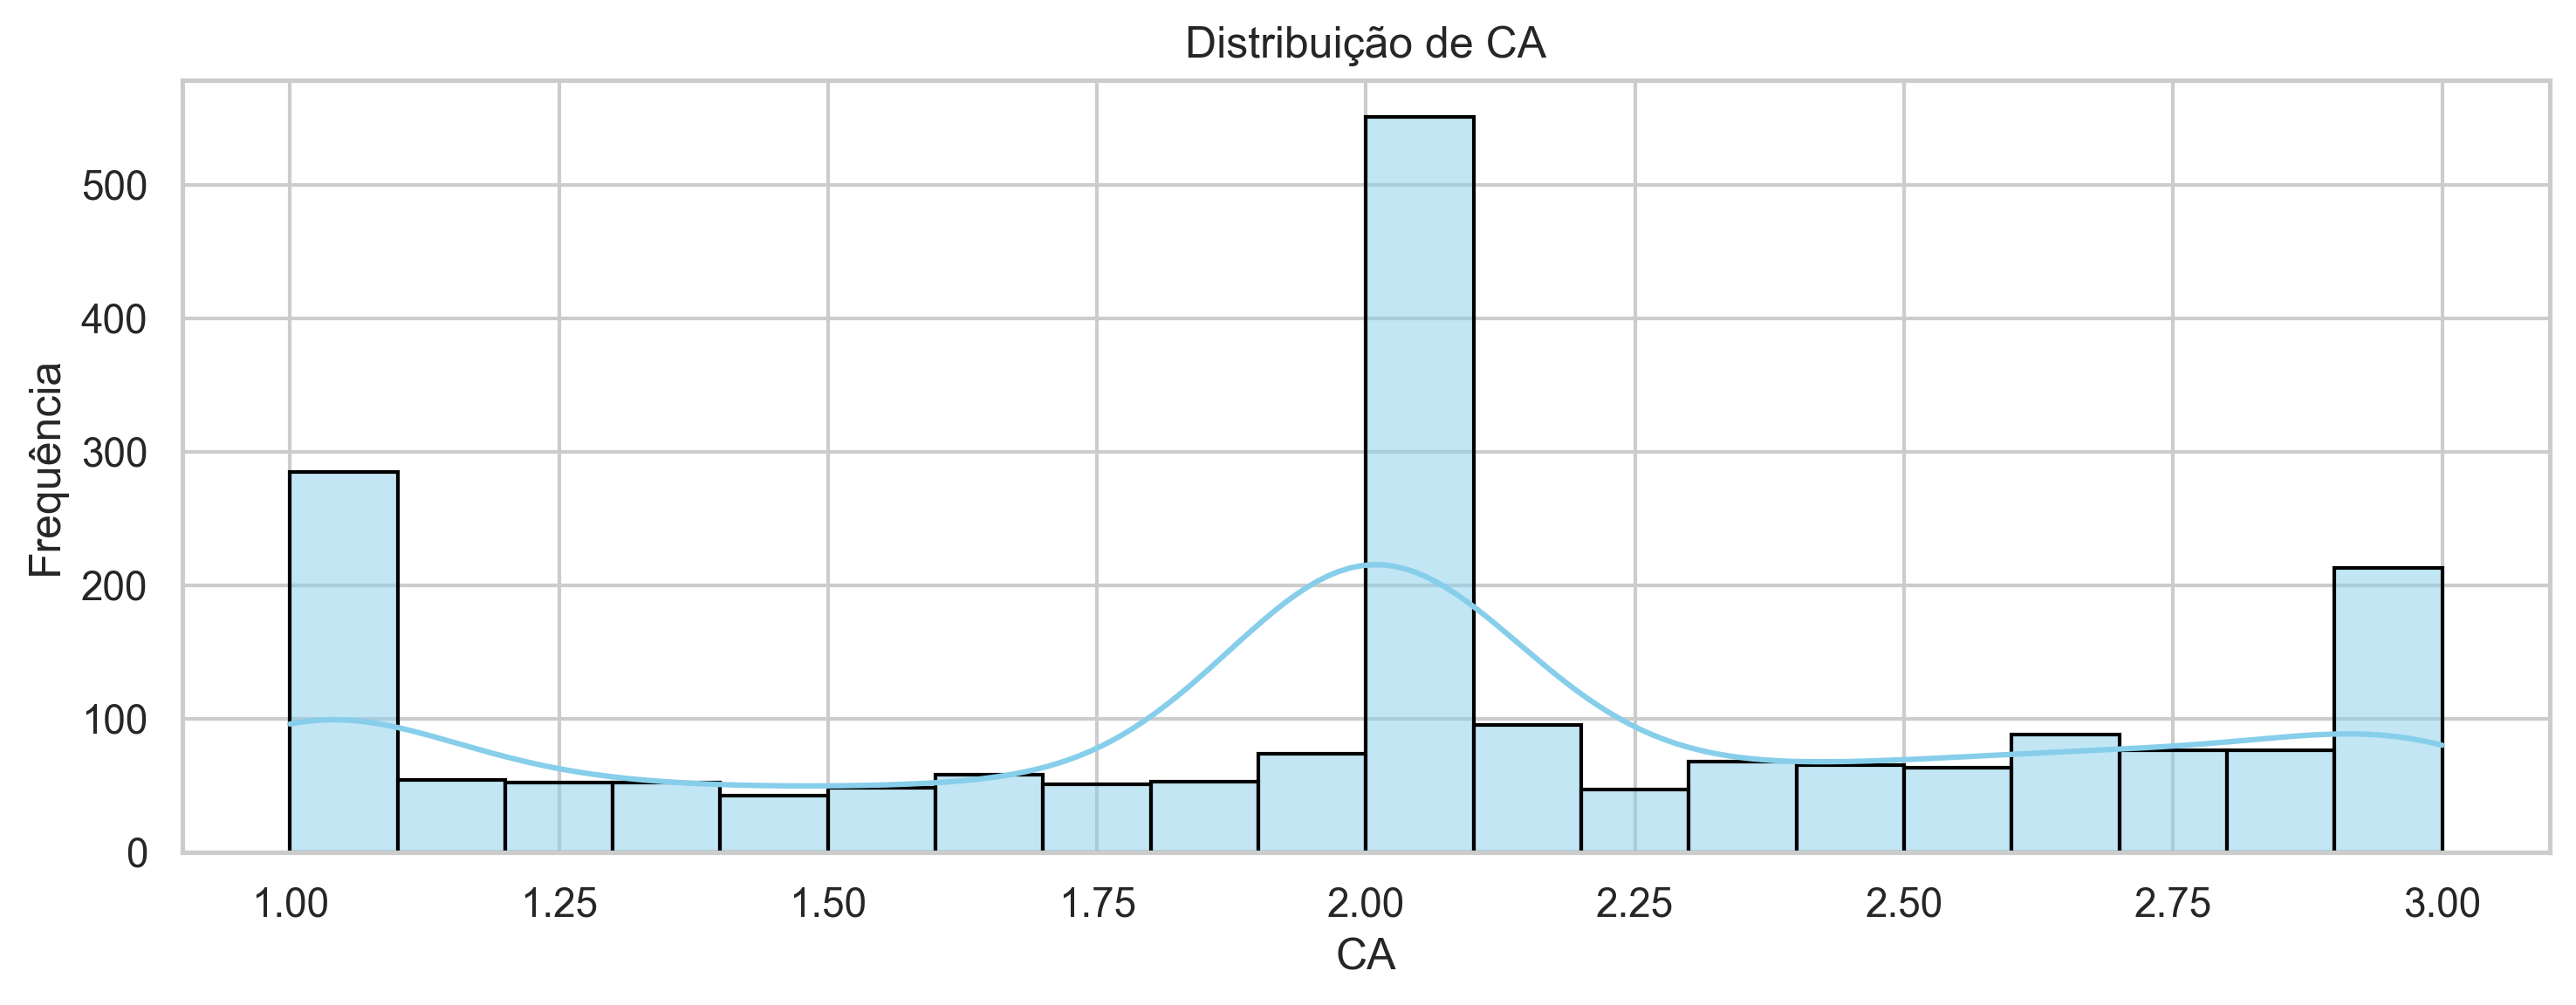

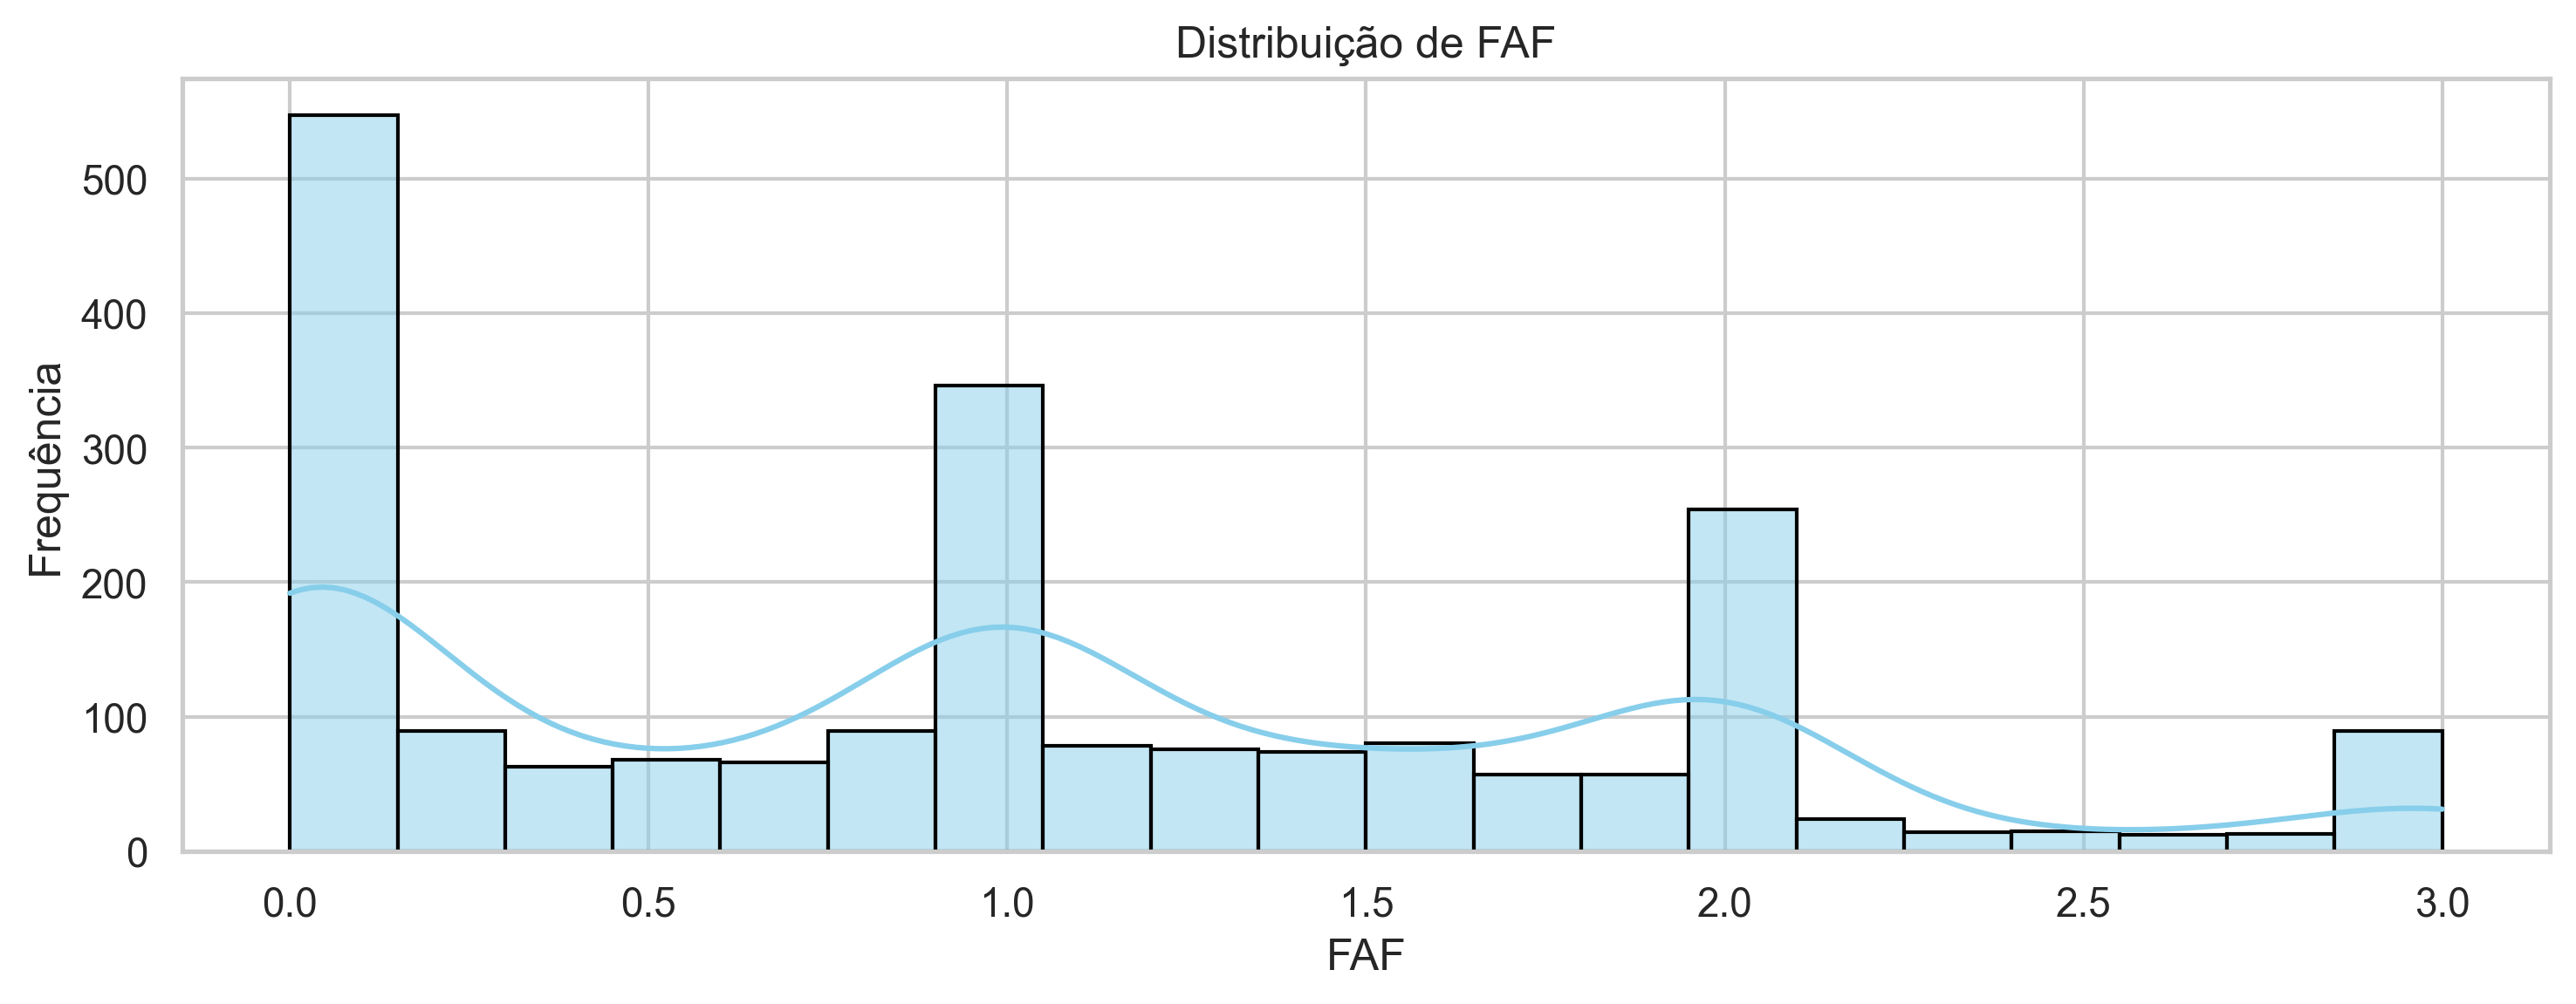

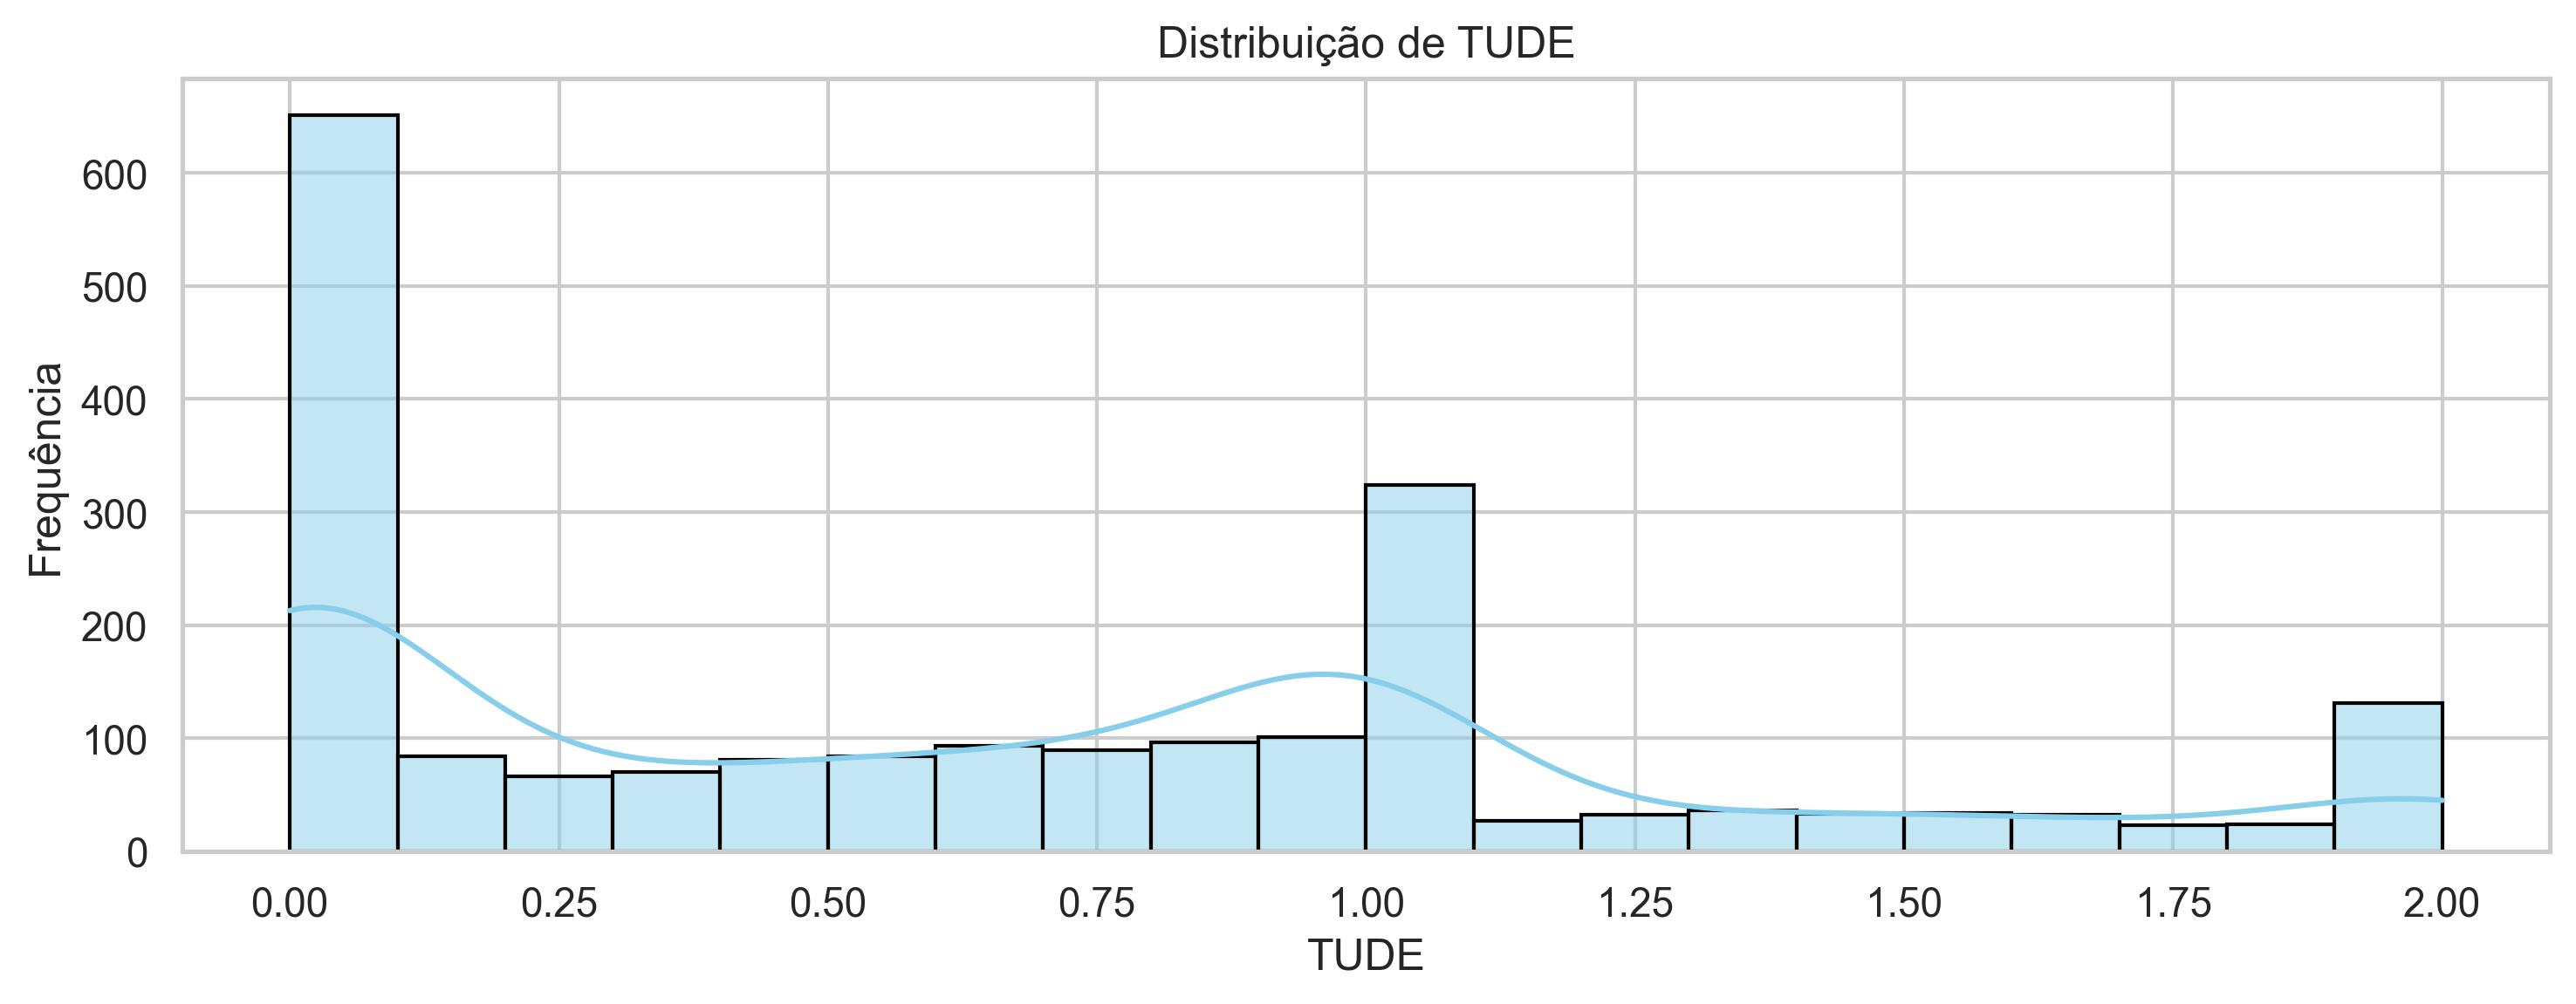

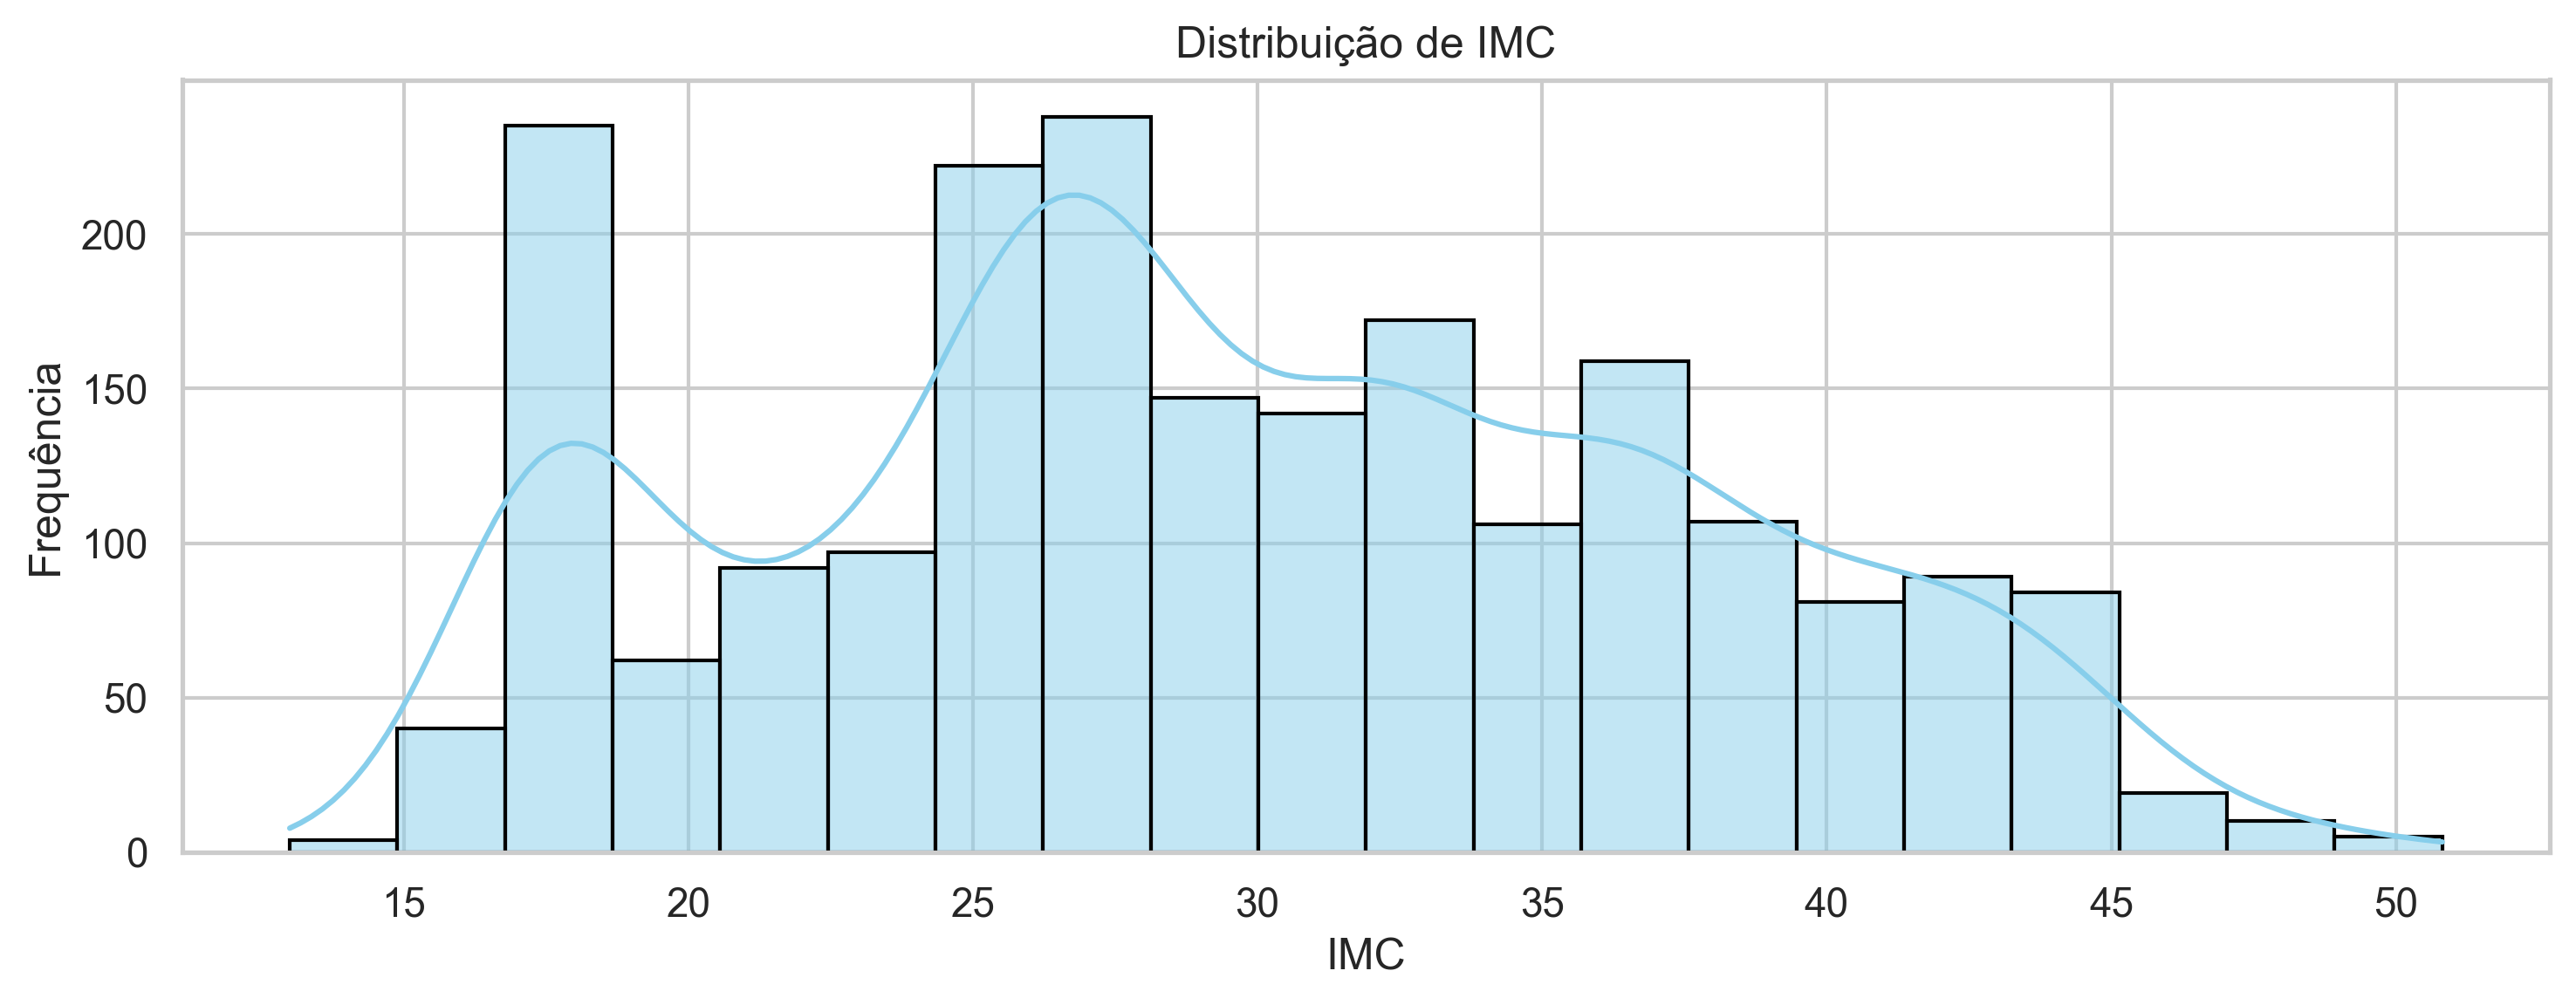

In [23]:
if not skip_graficos:
    sns.set(style="whitegrid")
    hist_columns_plot = ['FCV', 'NRP', 'CA', 'FAF', 'TUDE', 'IMC']

    for idx, etiqueta_serie in enumerate(hist_columns_plot):
        histograma(
            dados=dados_analise[etiqueta_serie],
            grupos=20,
            kde=True,
            size_x=10,
            size_y=4,
            titulo=f"Distribuição de {etiqueta_serie}",
            etiqueta_x=etiqueta_serie,
            etiqueta_y="Frequência",
            color="skyblue",
            edgecolor="black",
        )

#### Pie Charts

A função ``tarte()`` retorna a ``Fig`` e o ``Axes`` para se poder personalizar mais o gráfico.
É também possível passar parâmetros adicionais (*kwargs*), os quais serão usados na invocação de ``pie()``. 

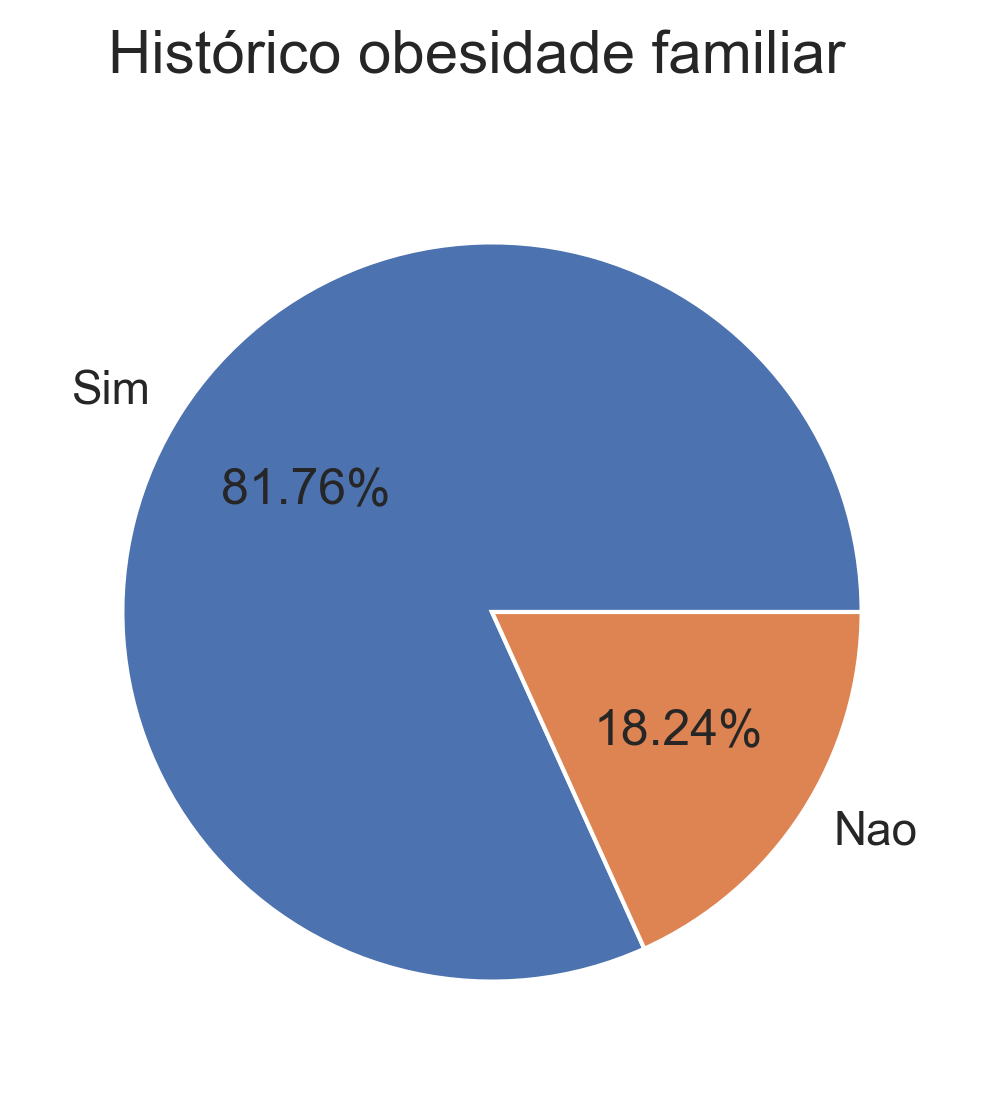

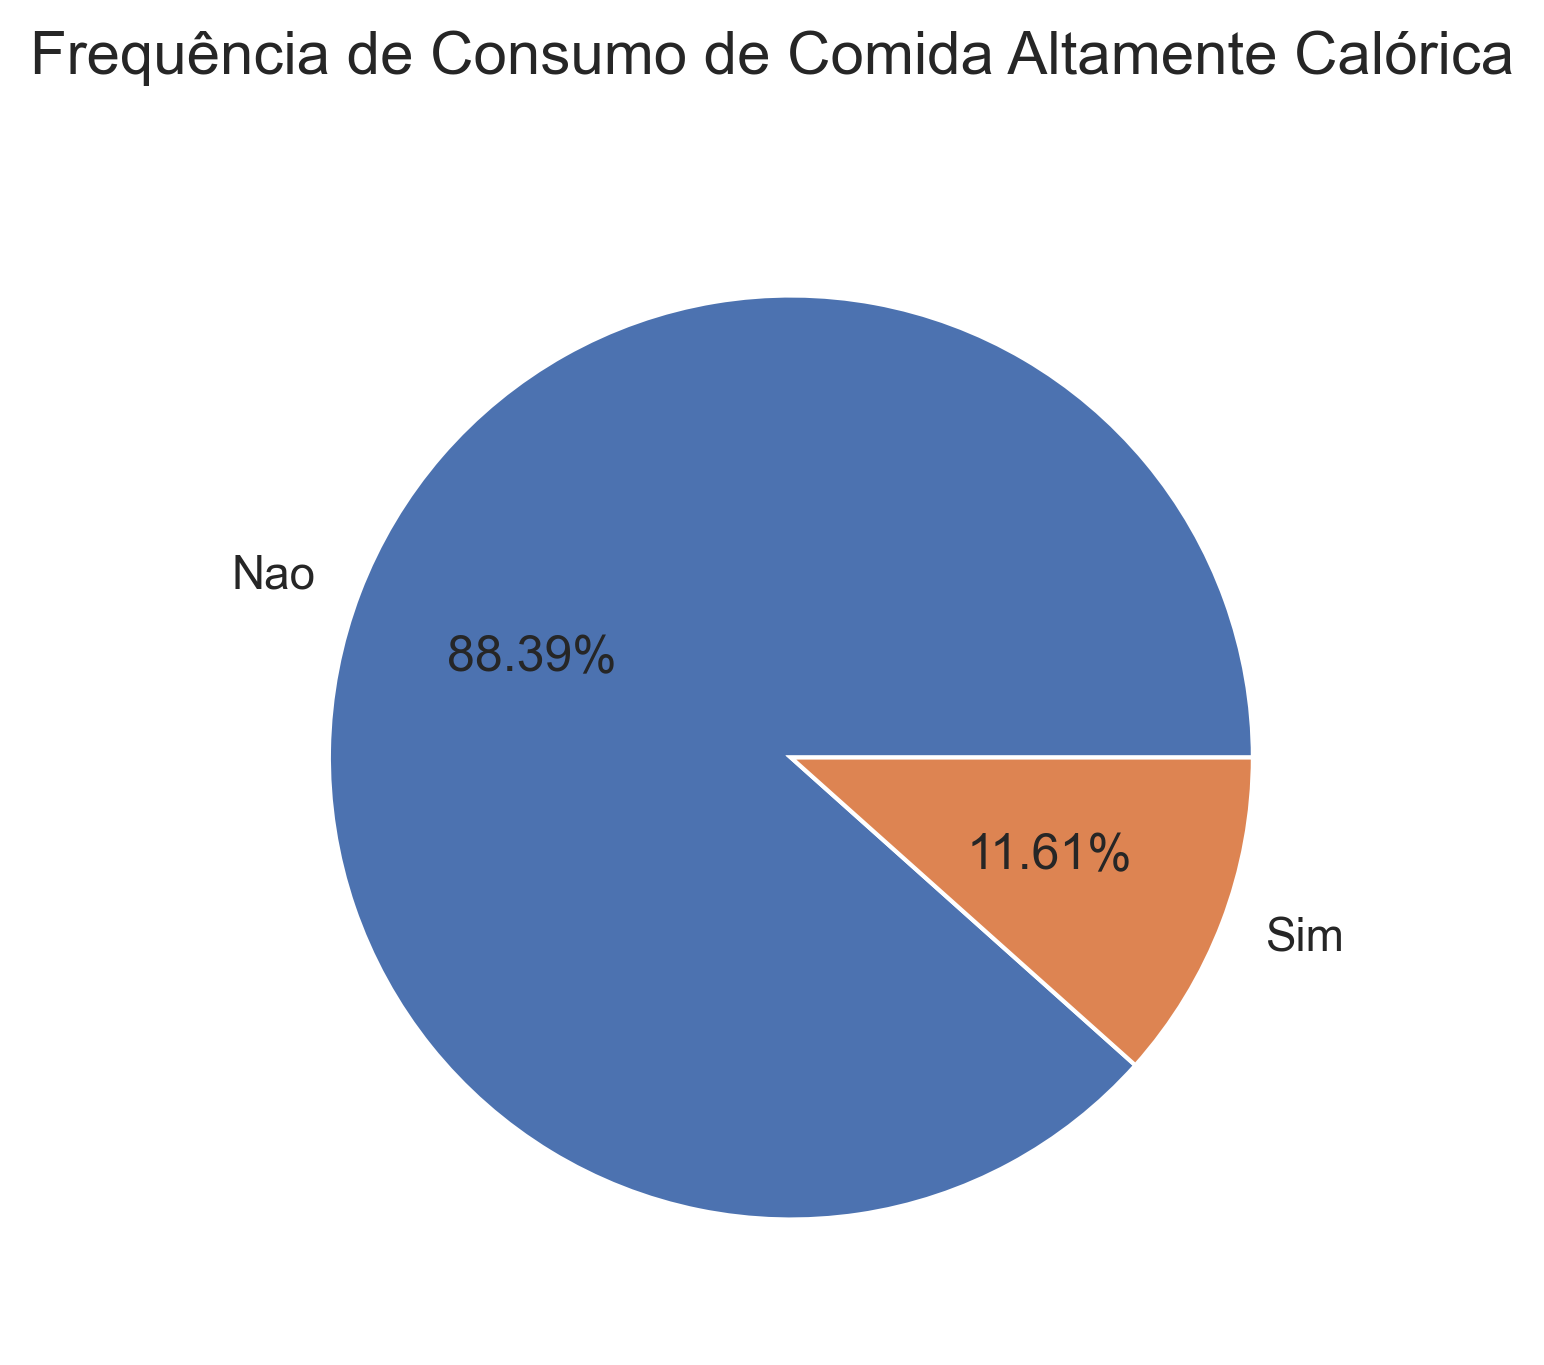

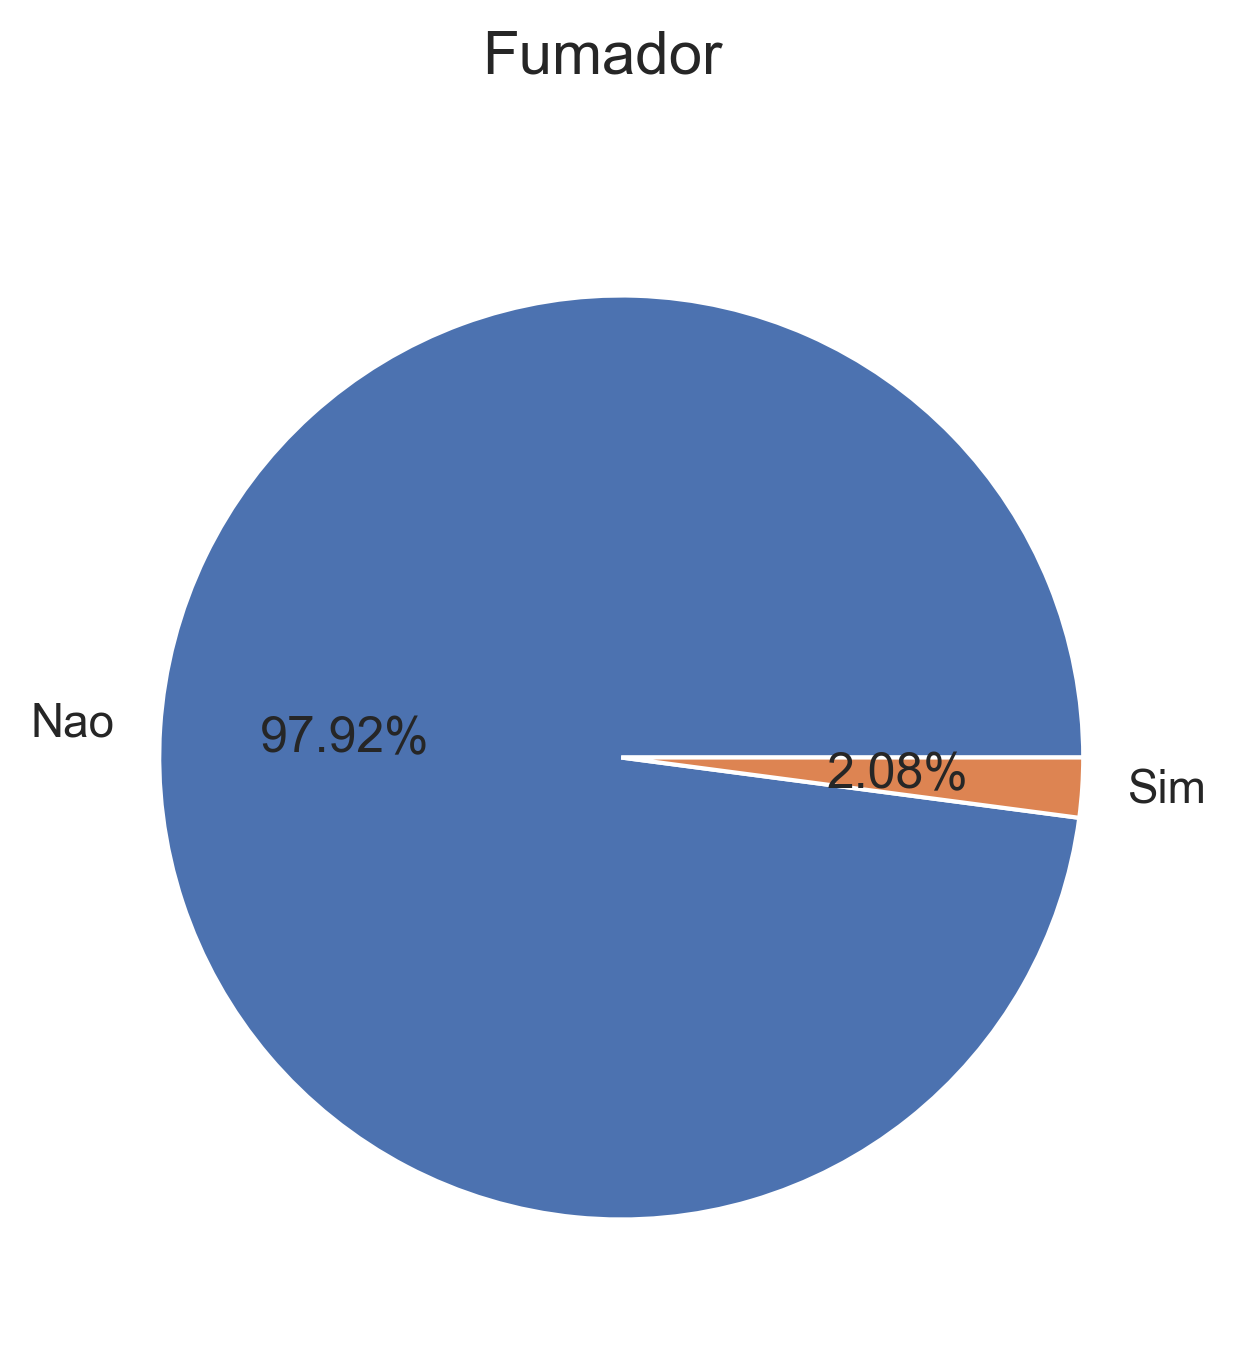

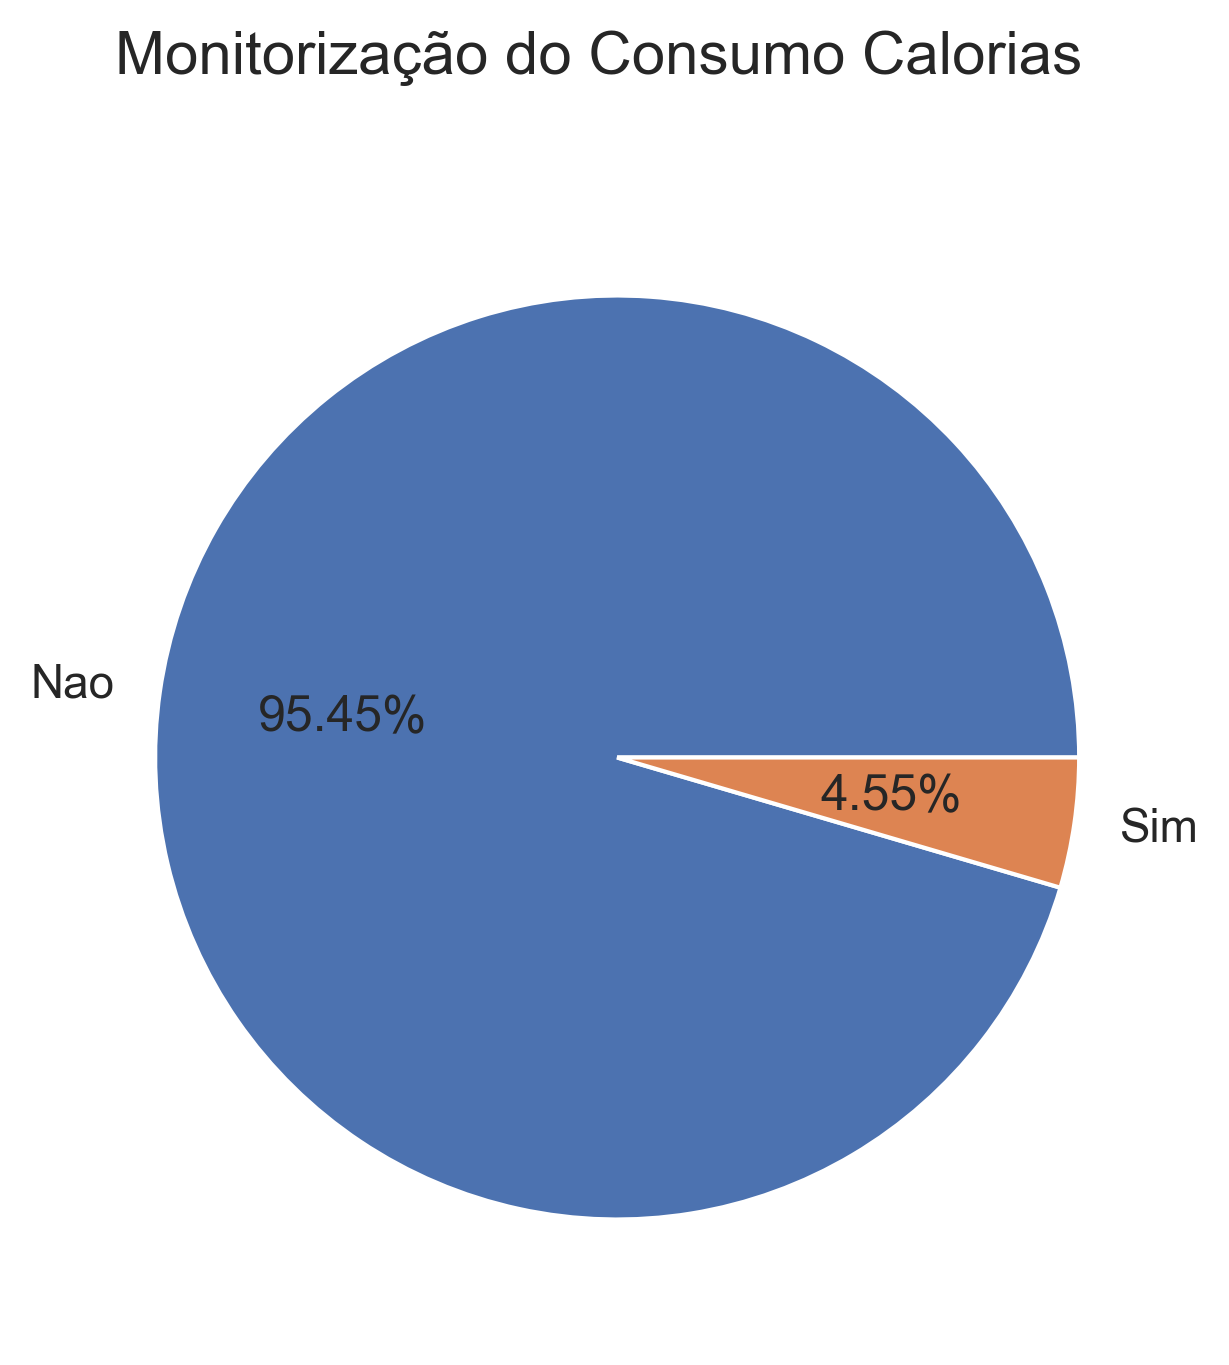

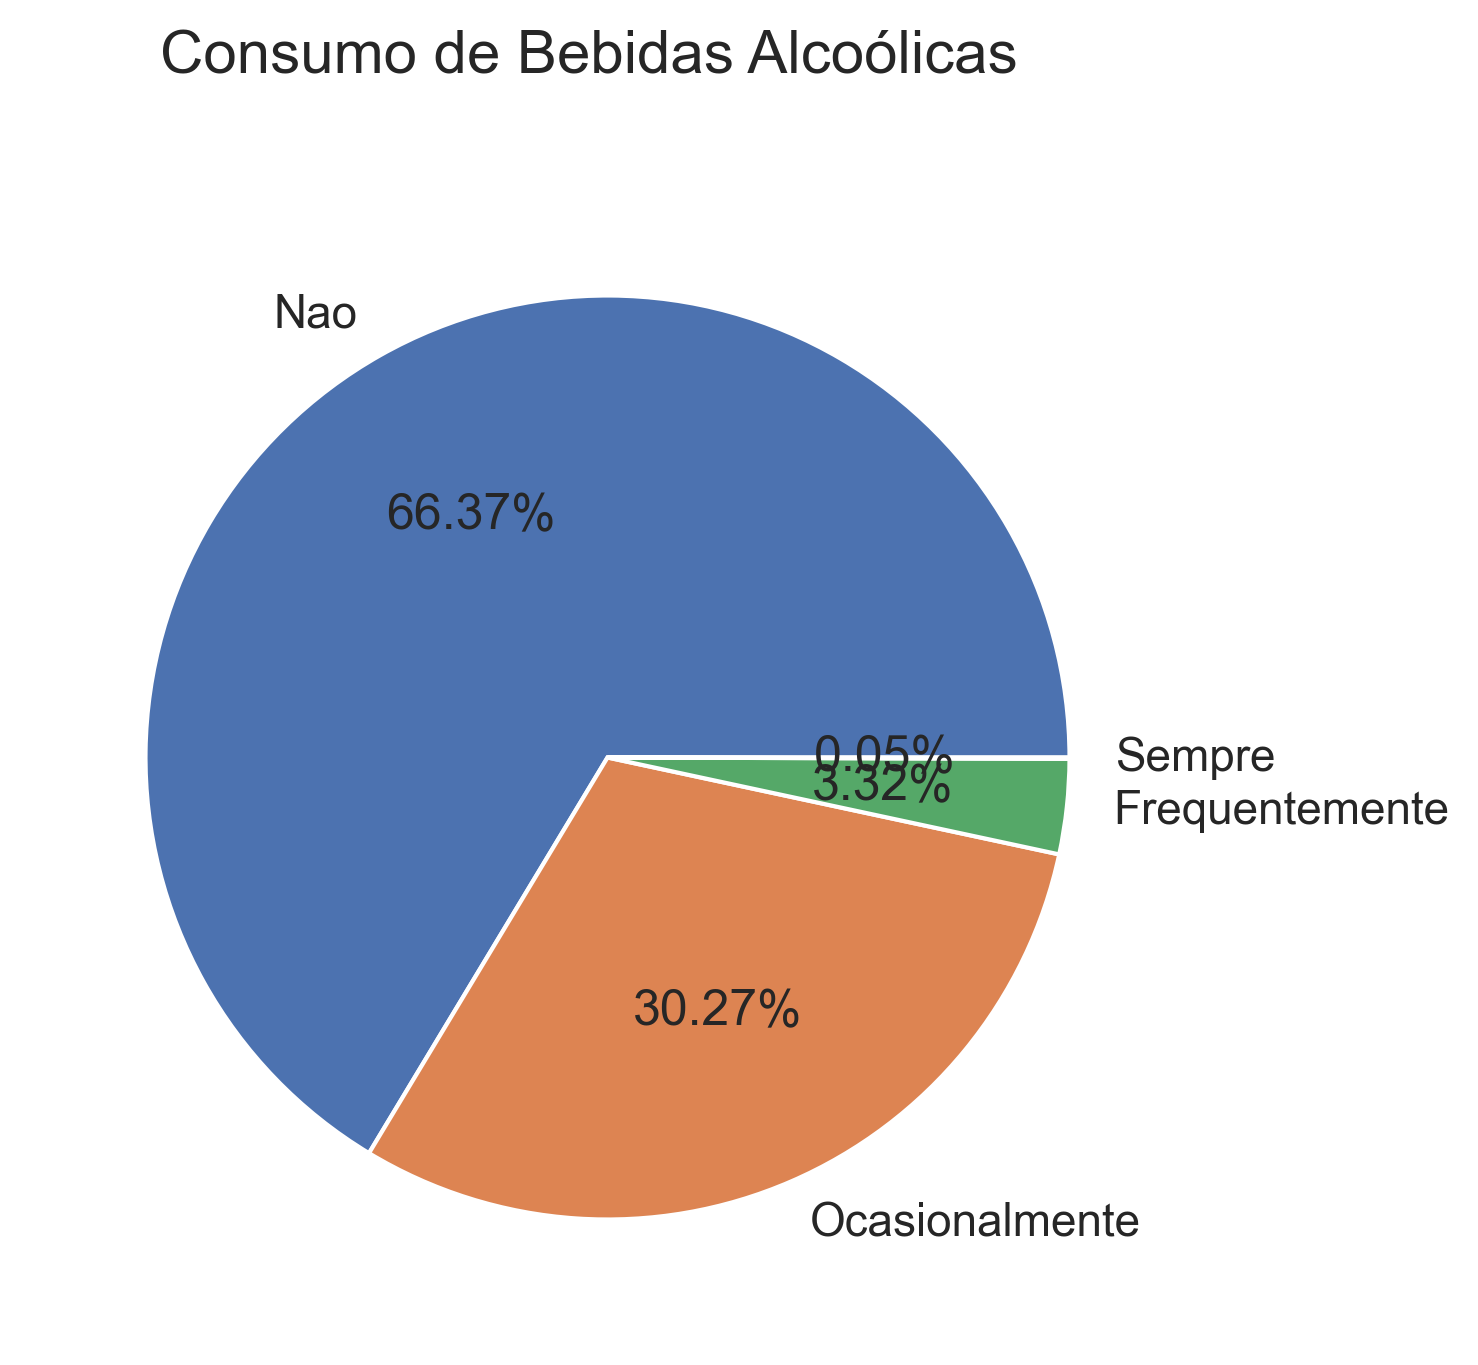

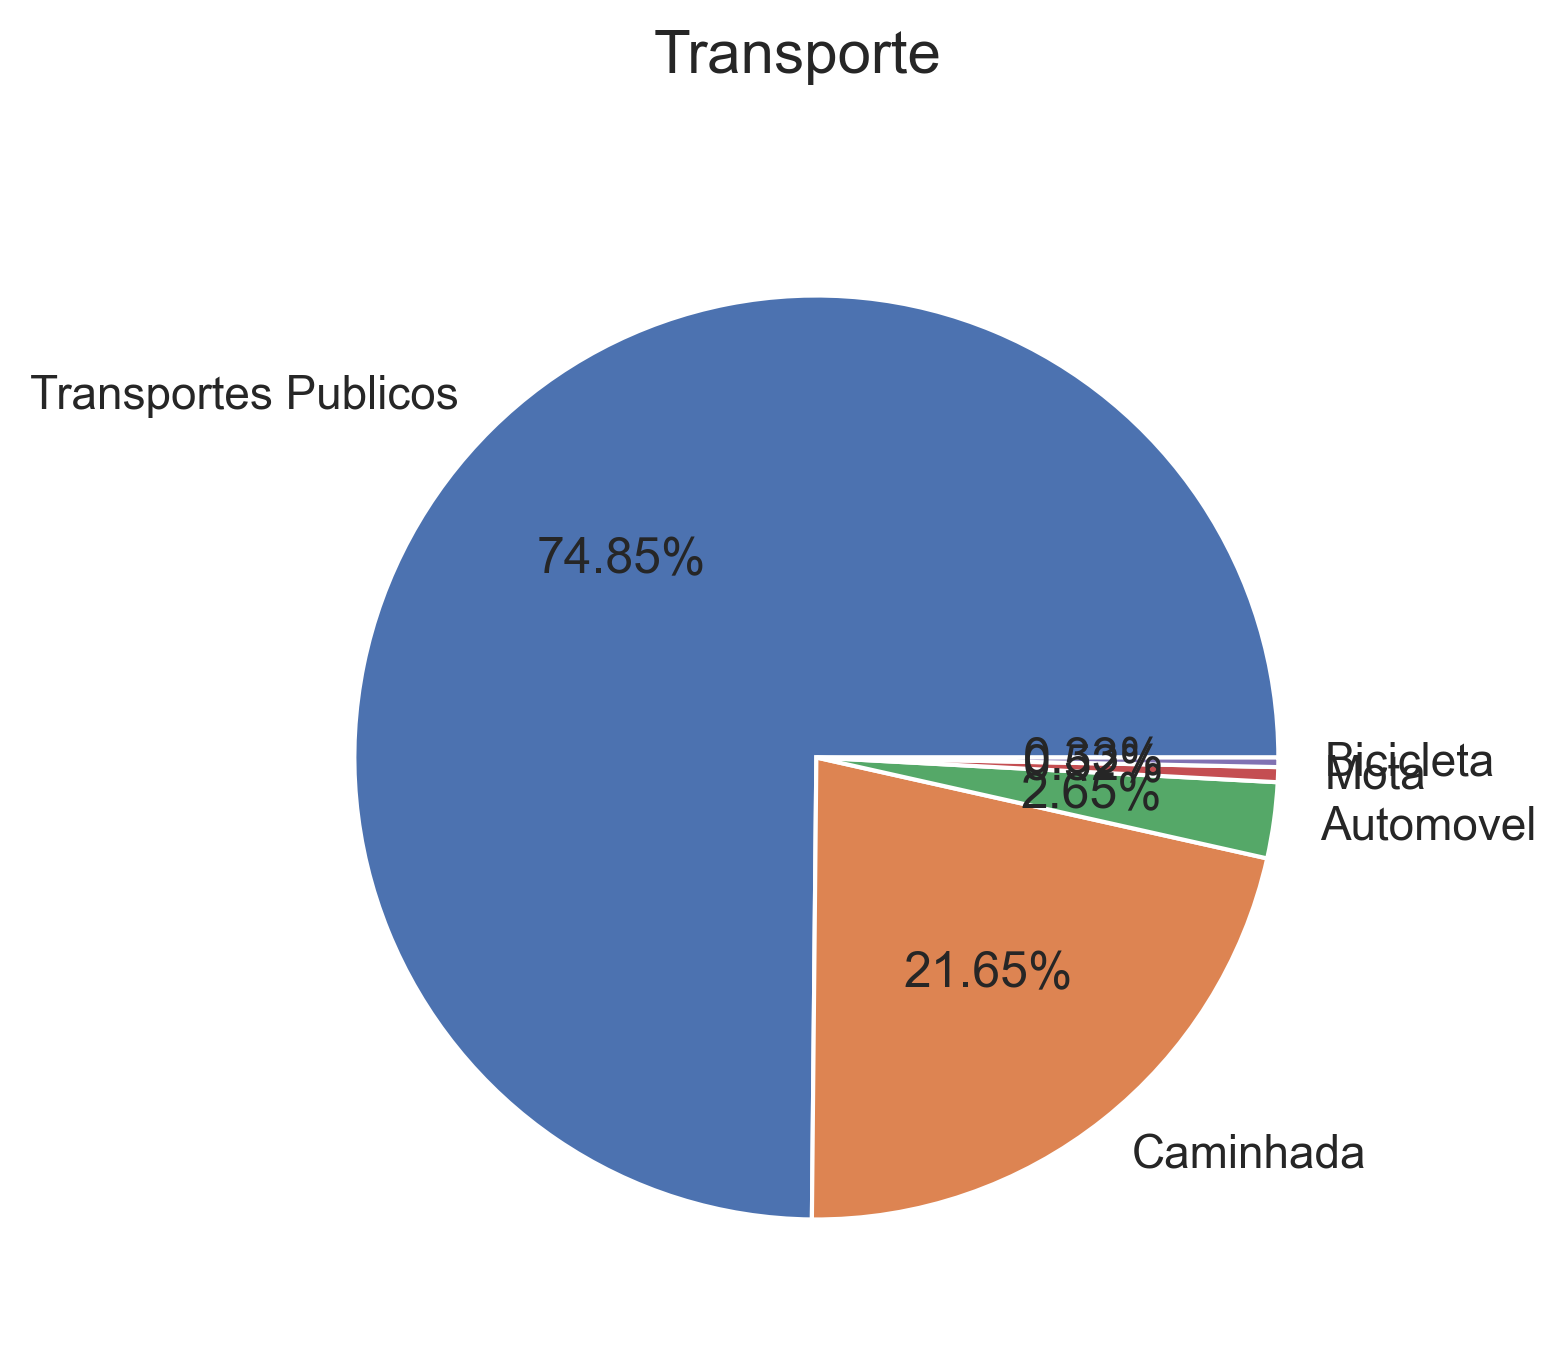

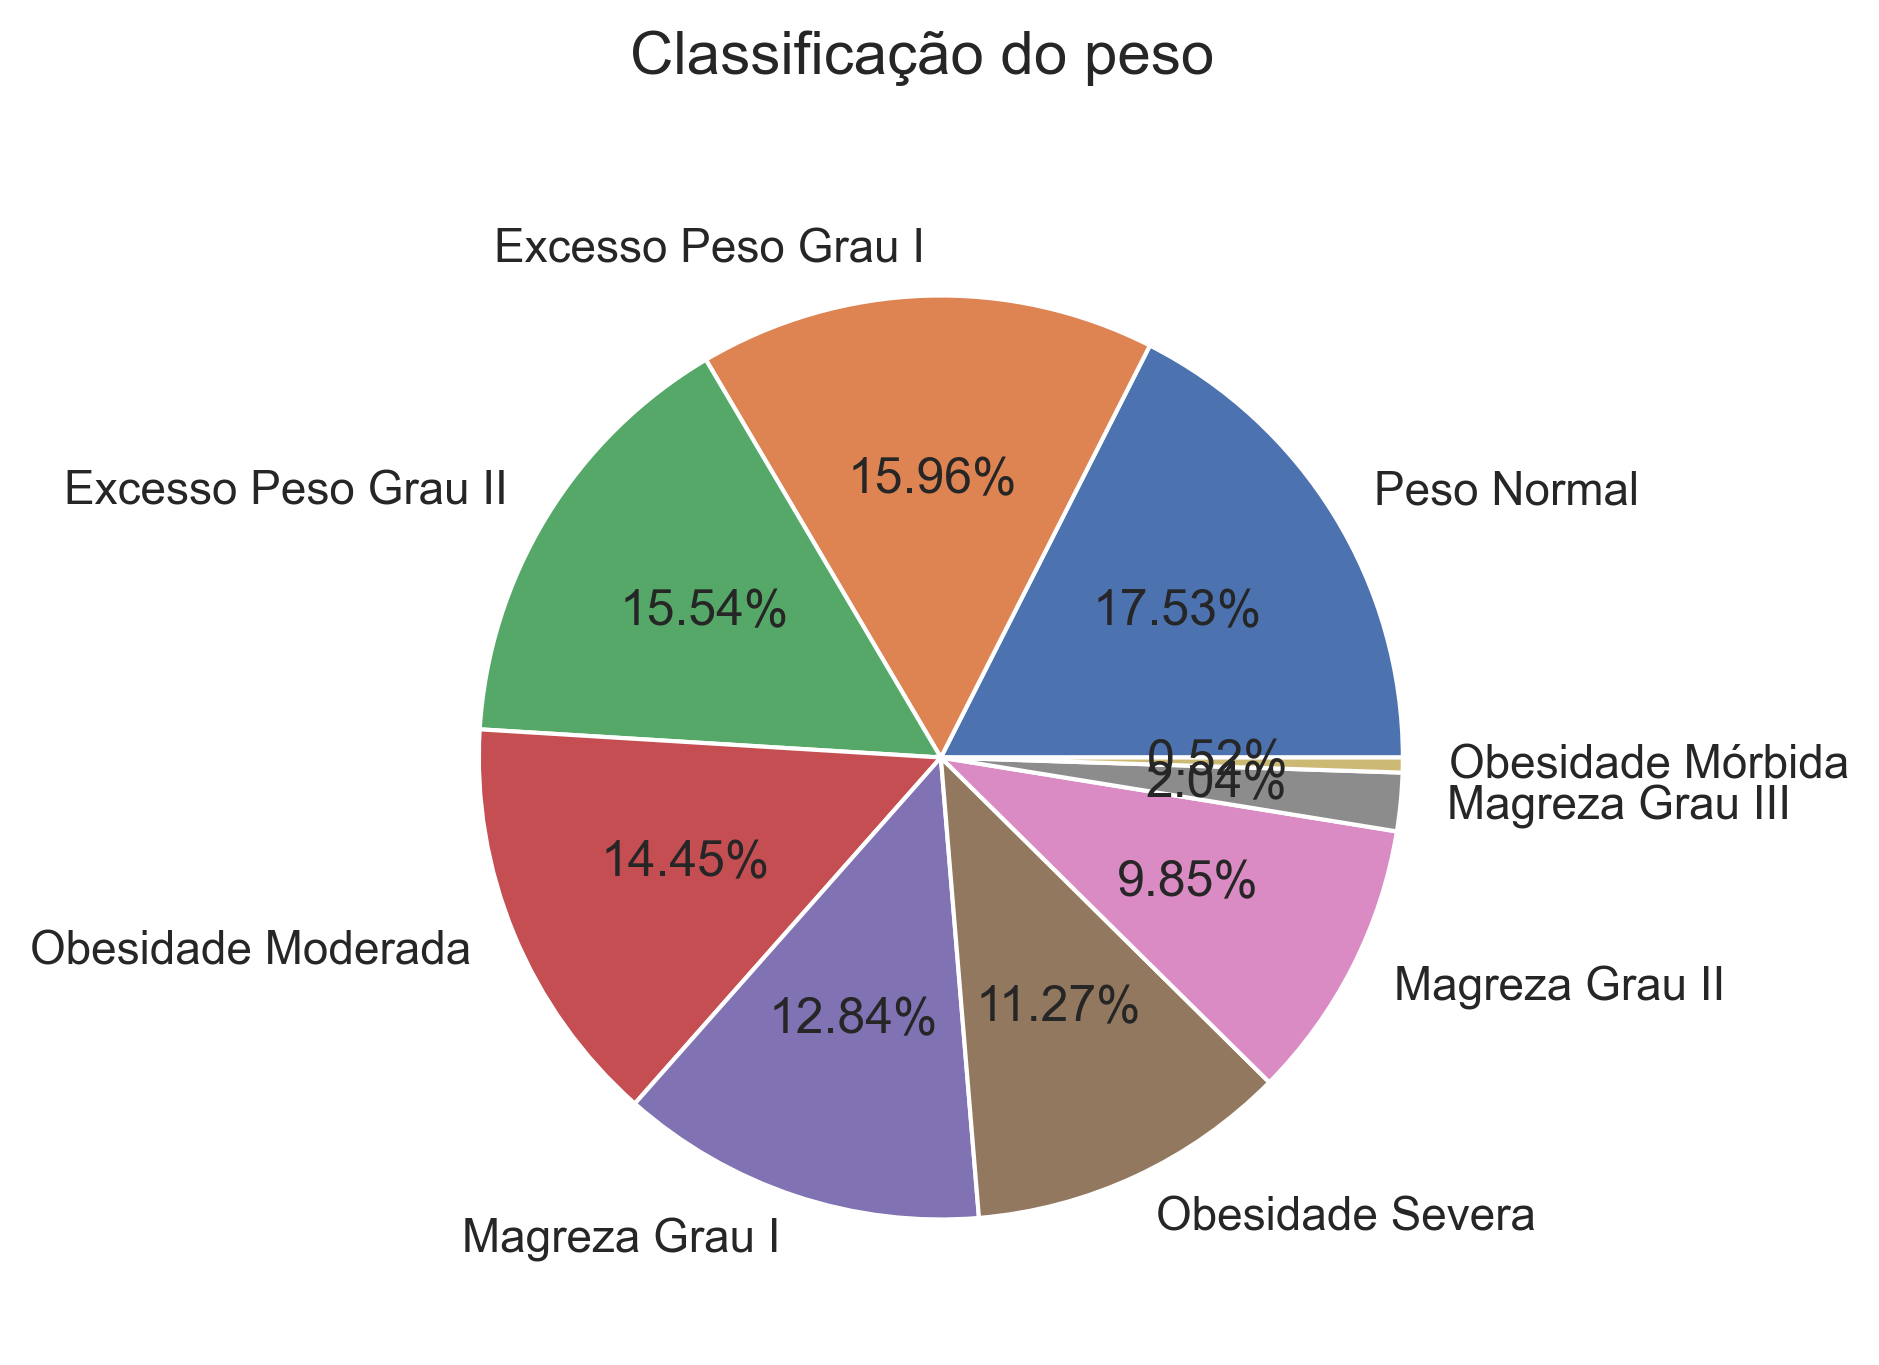

In [24]:
if not skip_graficos:
    tarte(
        dados=dados_analise["Historico_obesidade_familiar"].value_counts(),
        size_x=4,
        size_y=4,
        titulo="Histórico obesidade familiar",
        labels=dados_lidos["Historico_obesidade_familiar"].unique(),
    )

    tarte(
        dados=dados_analise["FCCAC"].value_counts(),
        size_x=5,
        size_y=5,
        titulo="Frequência de Consumo de Comida Altamente Calórica",
        labels=dados_lidos["FCCAC"].unique(),
    )

    tarte(
        dados=dados_analise["Fumador"].value_counts(),
        size_x=5,
        size_y=5,
        titulo="Fumador",
        labels=dados_lidos["Fumador"].unique(),
    )

    tarte(
        dados=dados_analise["MCC"].value_counts(),
        size_x=5,
        size_y=5,
        titulo="Monitorização do Consumo Calorias",
        labels=dados_lidos["MCC"].unique(),
    )

    tarte(
        dados=dados_analise["CBA"].value_counts(),
        size_x=5,
        size_y=5,
        titulo="Consumo de Bebidas Alcoólicas",
        labels=dados_lidos["CBA"].unique(),
    )

    tarte(
        dados=dados_analise["TRANS"].value_counts(),
        size_x=5,
        size_y=5,
        titulo="Transporte",
        labels=[undersplit(texto) for texto in dados_lidos["TRANS"].unique()],
    )

    tarte(
        dados=dados_analise["Label"].value_counts(),
        size_x=5,
        size_y=5,
        titulo="Classificação do peso",
        labels=[undersplit(texto) for texto in dados_lidos["Label"].unique()],
    )

#### visualização de outliers

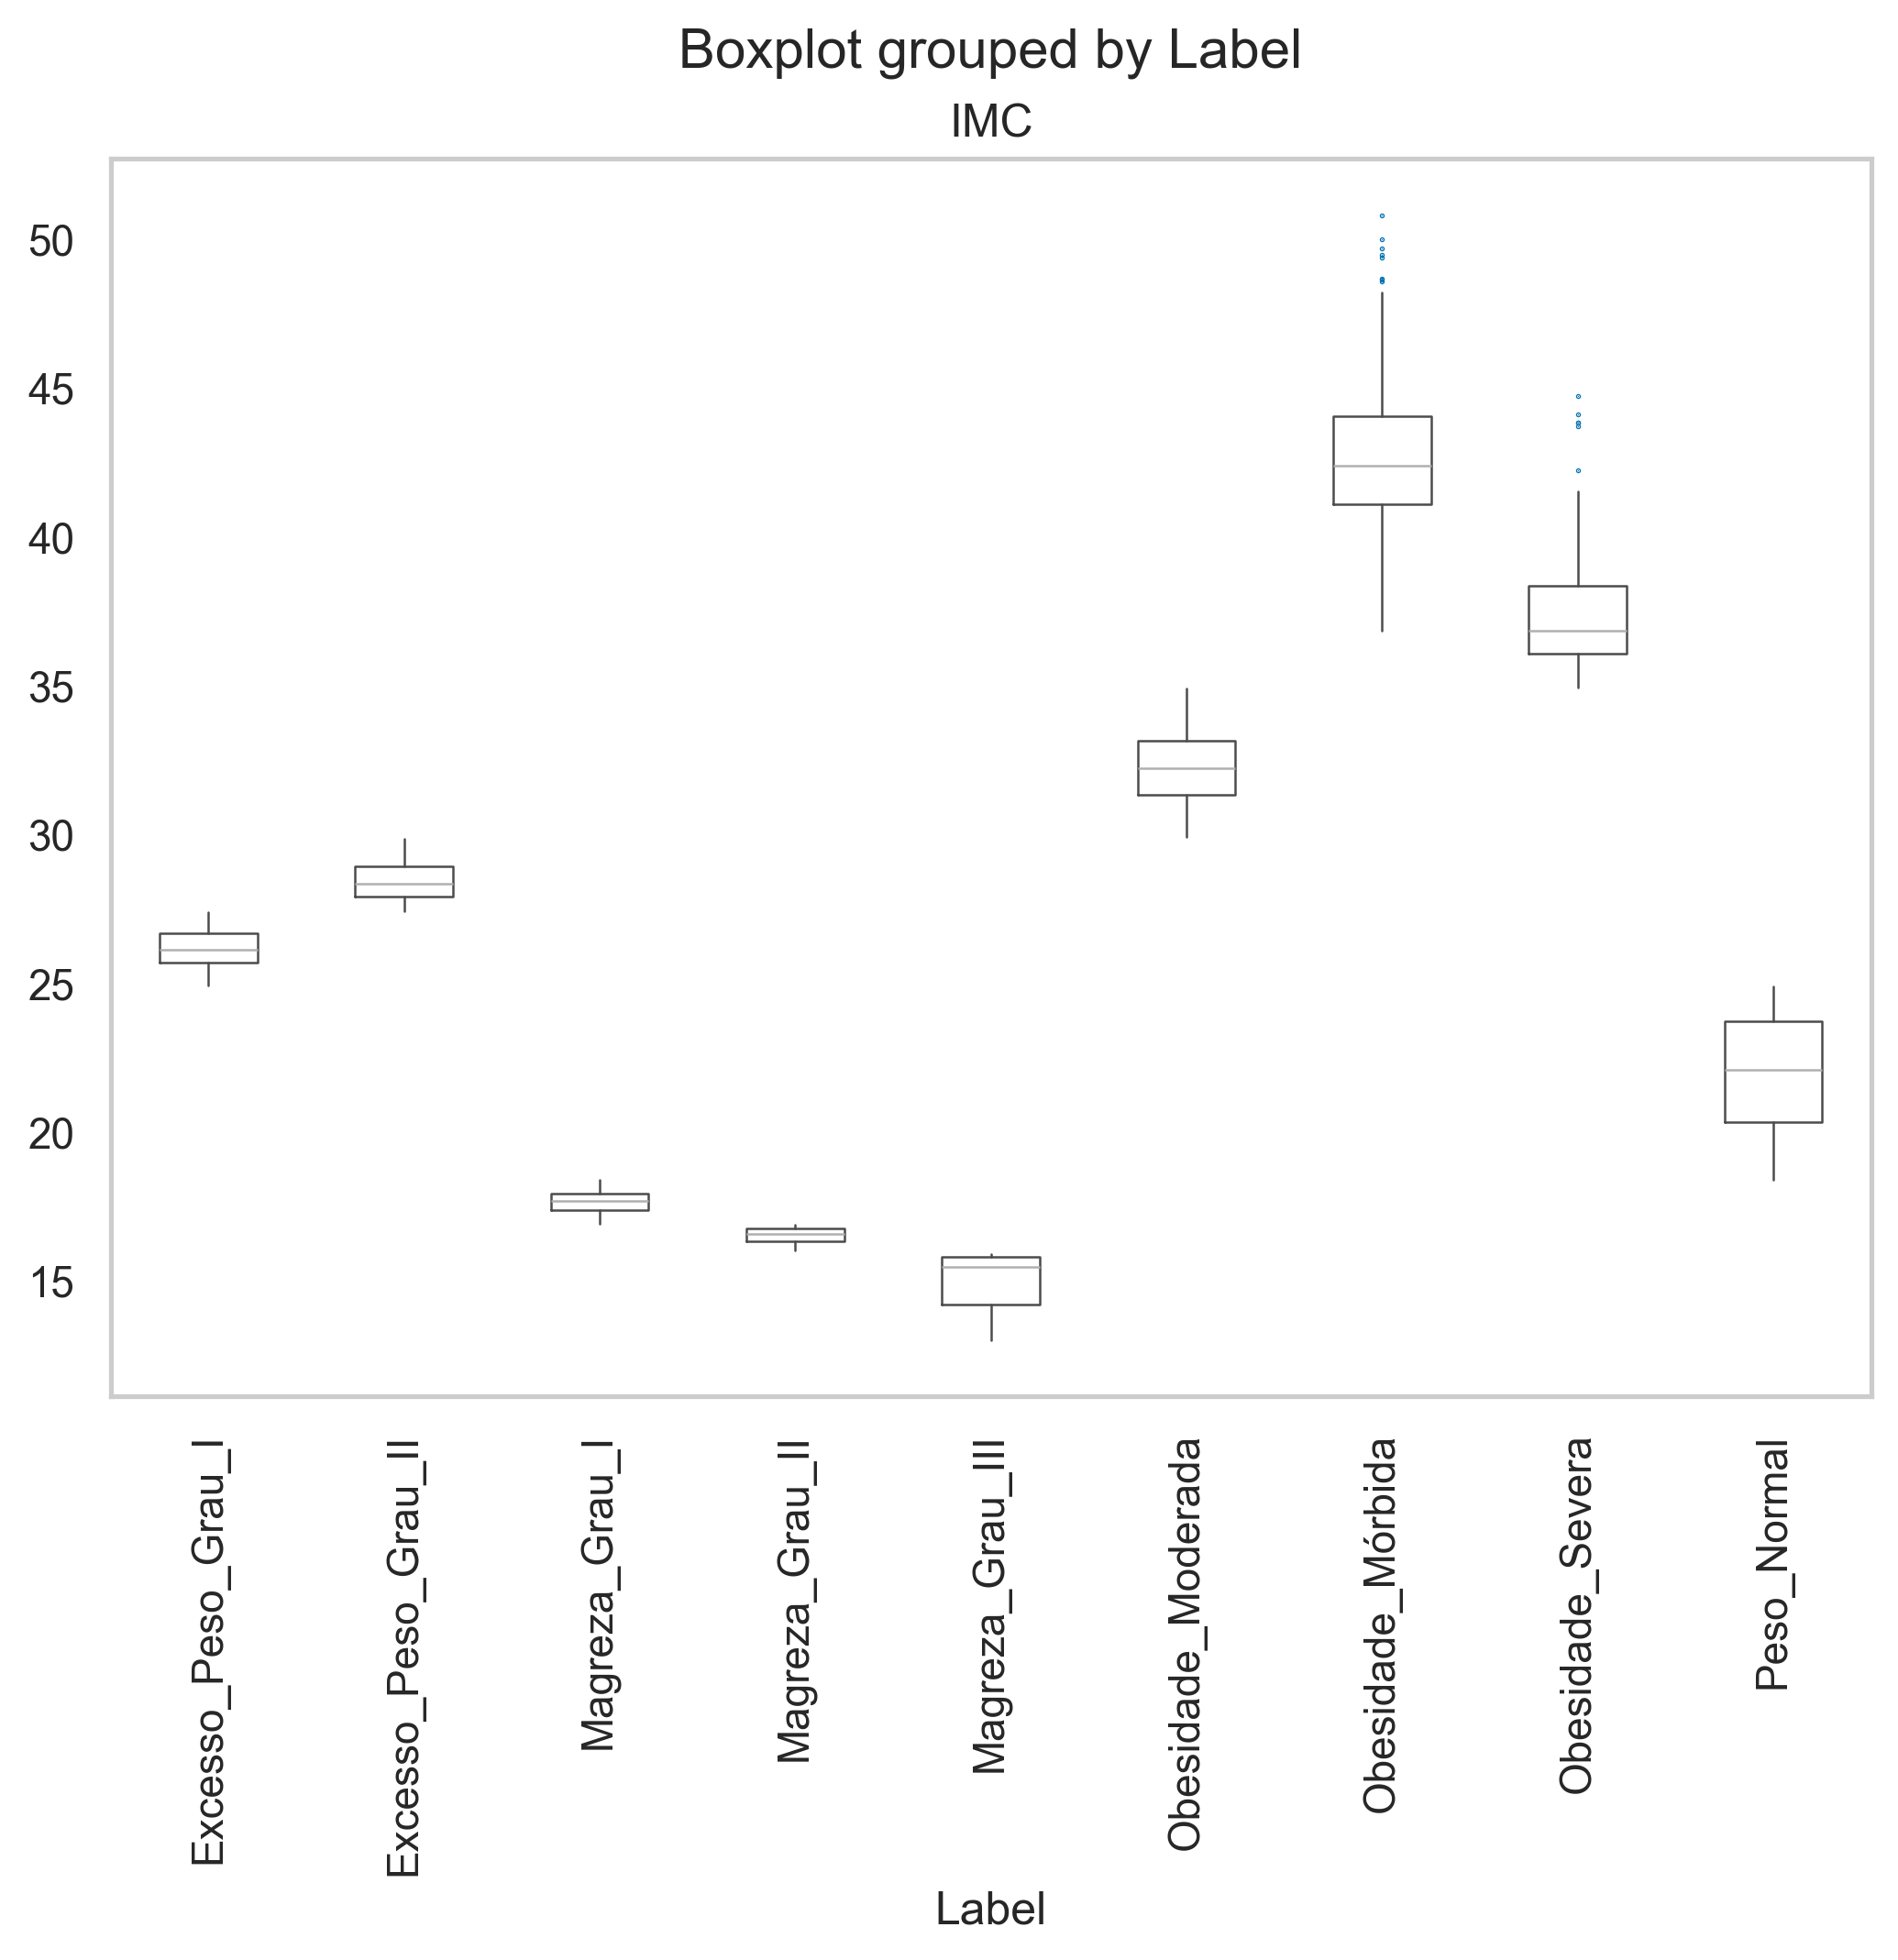

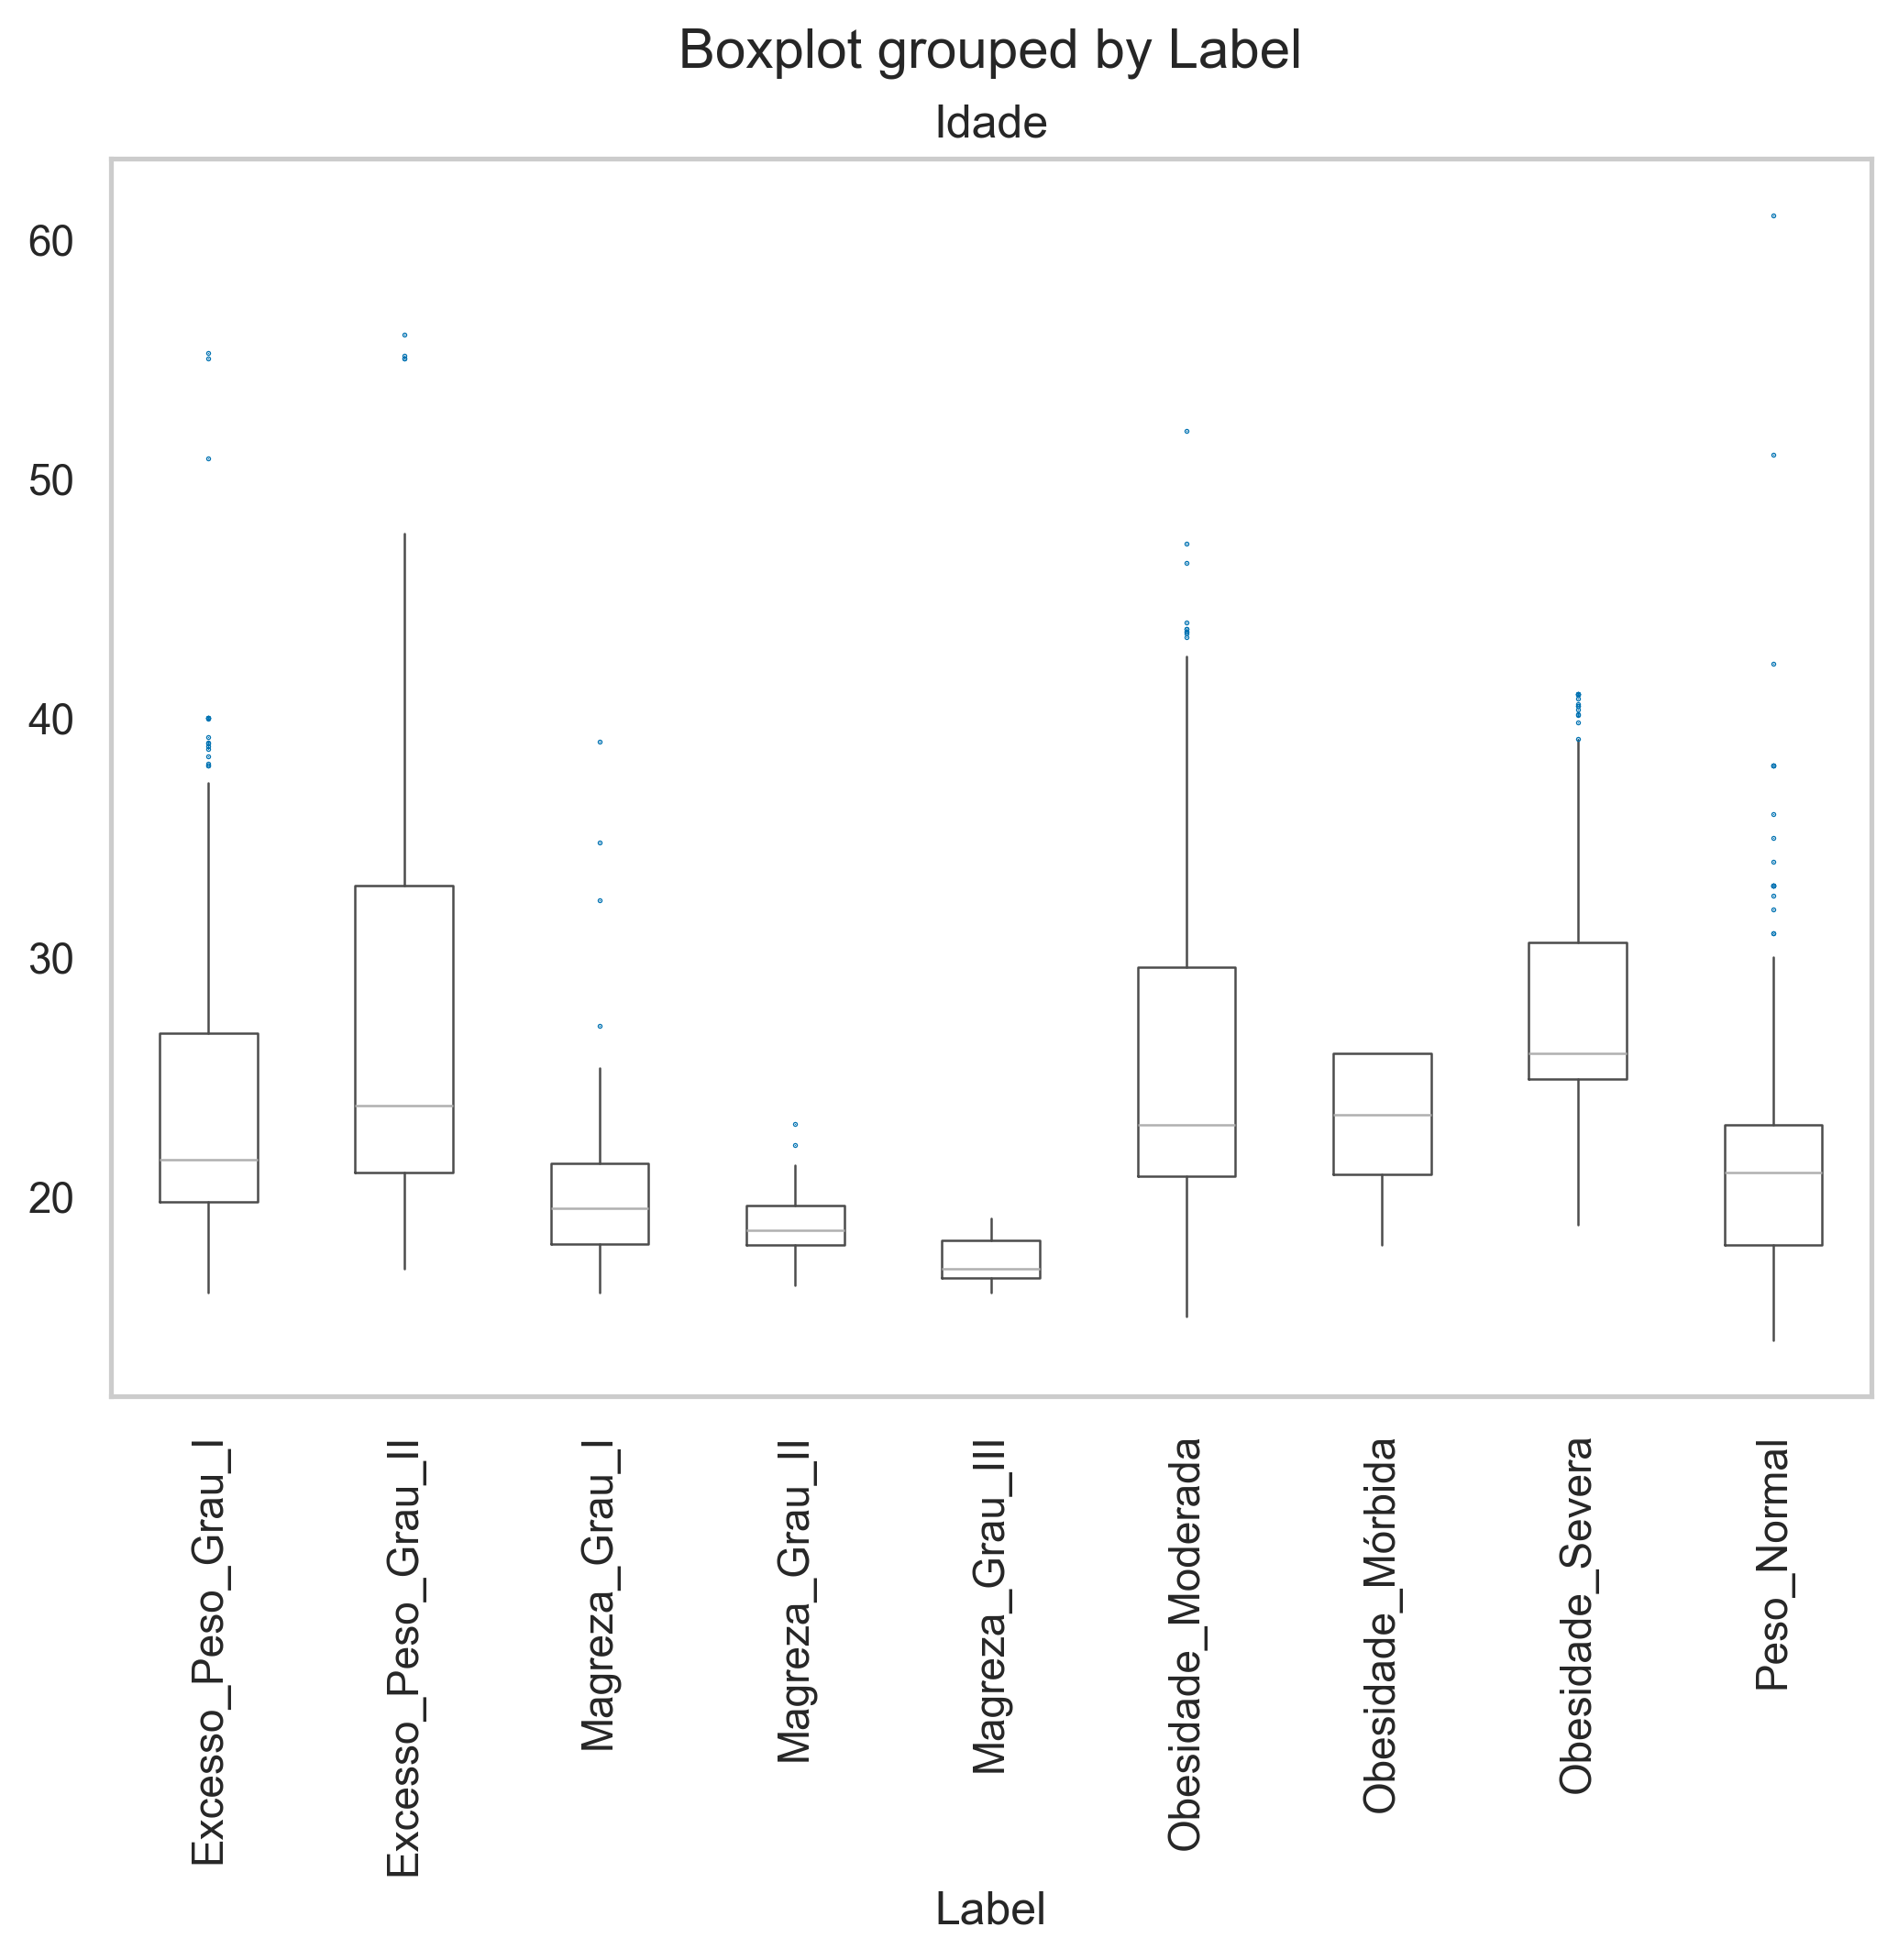

In [25]:
if not skip_graficos:
    boxplots_colunas = ["IMC", "Idade"]

    for coluna in boxplots_colunas:
        if (dados_analise[coluna].dtype != 'object'):
            dados_analise.boxplot(
                column=[coluna],
                by="Label",
                grid=False,
                figsize=(8, 6),
                return_type="dict",
                rot=90,
            )
            plt.title(coluna)

    plt.show()

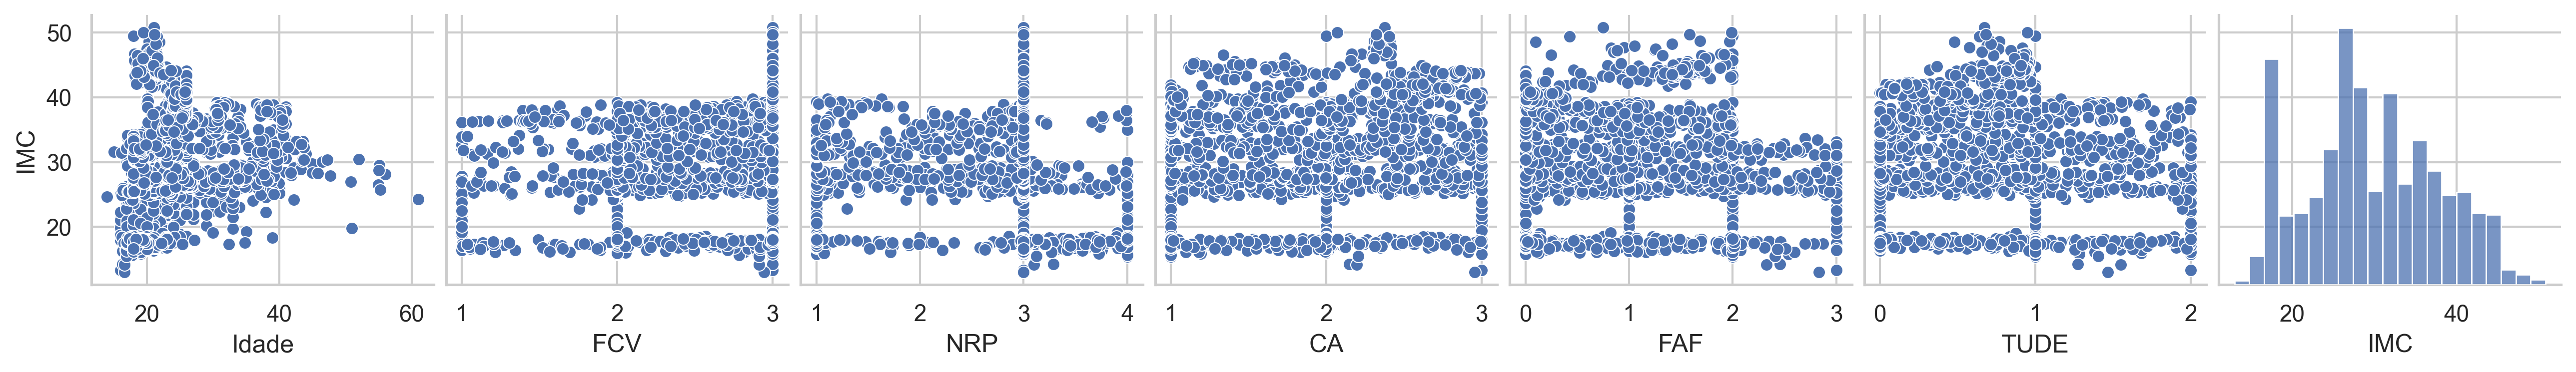

In [26]:
if not skip_graficos:
    sns.pairplot(data=dados_analise, x_vars=colunas_numericas, y_vars="IMC")

### 4.1.4

#### a) Identificação de NAN e "limpar" o dataset.

Verificar se existem valores nulos.

In [27]:
dados_analise[dados_analise.isnull().any(axis=1)]

Empty DataFrame
Columns: [Genero, Idade, Historico_obesidade_familiar, FCCAC, FCV, NRP, CCER, Fumador, CA, MCC, FAF, TUDE, CBA, TRANS, Label, IMC]
Index: []

Verificar se existem valores NaN

In [28]:
dados_analise[dados_analise.isna().any(axis=1)]

Empty DataFrame
Columns: [Genero, Idade, Historico_obesidade_familiar, FCCAC, FCV, NRP, CCER, Fumador, CA, MCC, FAF, TUDE, CBA, TRANS, Label, IMC]
Index: []

#### Notas sobre o pré-processamento dos dados

Não foram encontrados valores nulos, nem valor **NaN**, não sendo por isso necessário fazer tratamento adicionais ao dados neste contexto. 

Algum do trabalho de limpeza foi realizado do ponto *4.1.2*. 

TODO: Comentário sobre dados inconsistentes e outliers
TODO: Selecionar atributos (?)


#### Normalização

A normalização consiste em transformar o intervalo de valores de um atributo em valores compreendidos entre **0** e **1**, para eliminar os efeitos da escala utilizada.

Podemos utilizar o ``MinMaxScaler``. Apenas as colunas de valores numéricos devem ser normalizadas:

Idade, FCV, NRP, CA, FAF, TUDE, IMC
 

In [29]:
scaler = MinMaxScaler()
dados_analise.loc[:, colunas_numericas] = scaler.fit_transform(dados_analise.loc[:, colunas_numericas])
dados_analise

Genero     Idade Historico_obesidade_familiar FCCAC  FCV       NRP  \
0      Feminino  0.148936                          Sim   Nao  0.5  0.666667   
1      Feminino  0.148936                          Sim   Nao  1.0  0.666667   
2     Masculino  0.191489                          Sim   Nao  0.5  0.666667   
3     Masculino  0.276596                          Nao   Nao  1.0  0.666667   
4     Masculino  0.170213                          Nao   Nao  0.5  0.000000   
...         ...       ...                          ...   ...  ...       ...   
2106   Feminino  0.148443                          Sim   Sim  1.0  0.666667   
2107   Feminino  0.169850                          Sim   Sim  1.0  0.666667   
2108   Feminino  0.181362                          Sim   Sim  1.0  0.666667   
2109   Feminino  0.220467                          Sim   Sim  1.0  0.666667   
2110   Feminino  0.205632                          Sim   Sim  1.0  0.666667   

                CCER Fumador        CA  MCC       FAF      TUDE  \
0     Ocasionalmente     Nao  0.500000  Nao  0.000000  0.500000   
1     Ocasionalmente     Sim  1.000000  Sim  1.000000  0.000000   
2     Ocasionalmente     Nao  0.500000  Nao  0.666667  0.500000   
3     Ocasionalmente     Nao  0.500000  Nao  0.666667  0.000000   
4     Ocasionalmente     Nao  0.500000  Nao  0.000000  0.000000   
...              ...     ...       ...  ...       ...       ...   
2106  Ocasionalmente     Nao  0.364070  Nao  0.558756  0.453124   
2107  Ocasionalmente     Nao  0.502565  Nao  0.447130  0.299635   
2108  Ocasionalmente     Nao  0.527097  Nao  0.471403  0.323144   
2109  Ocasionalmente     Nao  0.926170  Nao  0.379702  0.293017   
2110  Ocasionalmente     Nao  0.931757  Nao  0.342151  0.357069   

                 CBA                 TRANS                 Label       IMC  
0                Nao  Transportes_Publicos           Peso_Normal  0.301162  
1     Ocasionalmente  Transportes_Publicos           Peso_Normal  0.297240  
2     Frequentemente  Transportes_Publicos           Peso_Normal  0.284736  
3     Frequentemente             Caminhada   Excesso_Peso_Grau_I  0.366359  
4     Ocasionalmente  Transportes_Publicos  Excesso_Peso_Grau_II  0.405778  
...              ...                   ...                   ...       ...  
2106  Ocasionalmente  Transportes_Publicos     Obesidade_Mórbida  0.843697  
2107  Ocasionalmente  Transportes_Publicos     Obesidade_Mórbida  0.813032  
2108  Ocasionalmente  Transportes_Publicos     Obesidade_Mórbida  0.807793  
2109  Ocasionalmente  Transportes_Publicos     Obesidade_Mórbida  0.821749  
2110  Ocasionalmente  Transportes_Publicos     Obesidade_Mórbida  0.823674  

[2111 rows x 16 columns]

#### Transformar classes em valores

Vamos fazer esta operação para as colunas em que apenas temos 2 classes:

* genero
* historico_obesidade_familiar
* FCCAC
* Fumador
* MCC

NOTA: No mesmo passo em que fazemos a conversão, mostramos os valores finais.

In [30]:
for coluna in colunas_classes_binarias:
    dados_analise[coluna] = label_encoder.fit_transform(dados_analise[coluna].values)
    etiqueta_e_valor(coluna, dados_analise[coluna].unique())

Genero: [0 1]
Historico_obesidade_familiar: [1 0]
FCCAC: [0 1]
Fumador: [0 1]
MCC: [0 1]


Para as colunas de classes com mais de 2 valores, vamos precisar de 2 abordagens, em algumas das operaçoes que vamos realizar precisamos de codificar os dados em valores numéricos, mas numa única coluna, enquanto que para outros precisamos de criar colunas "dummy" unado a função ``get_dummies`` do **pandas**.

Começamos por fazer um duplicado dos dados e tratar cada conjunto de uma forma diferente.

In [31]:
dados_com_dummies = dados_analise.copy()
dados_trabalho = dados_analise.copy()

#### Encoding das colunas com múltiplos valores

In [32]:
for coluna in colunas_classes_multiplos:
    dados_trabalho[coluna] = label_encoder.fit_transform(dados_trabalho[coluna].values)
    etiqueta_e_valor(coluna, dados_trabalho[coluna].unique())

CCER: [2 0 3 1]
CBA: [1 2 0 3]
TRANS: [4 2 0 3 1]


#### Gerar Dummies para as colunas de classes



CCER, CBA e TRANS

In [33]:
dados_com_dummies = pd.get_dummies(dados_com_dummies, dtype=float)

O **DataFrame** *dados_com_dummies* vai ser preciso para o ponto *4.2*, vamos guardar num ficheiro, que será depois aberto no outro notebook.

In [34]:
dados_com_dummies.to_csv(ficheiro_dummies)

### 4.1.5 Matriz de Correlação

Para esta matriz vamos utilizar os dados previamente guardados (**dados_trabalho**) antes da preparação dos atributos para utilização nas várias metodologias que se seguem.  

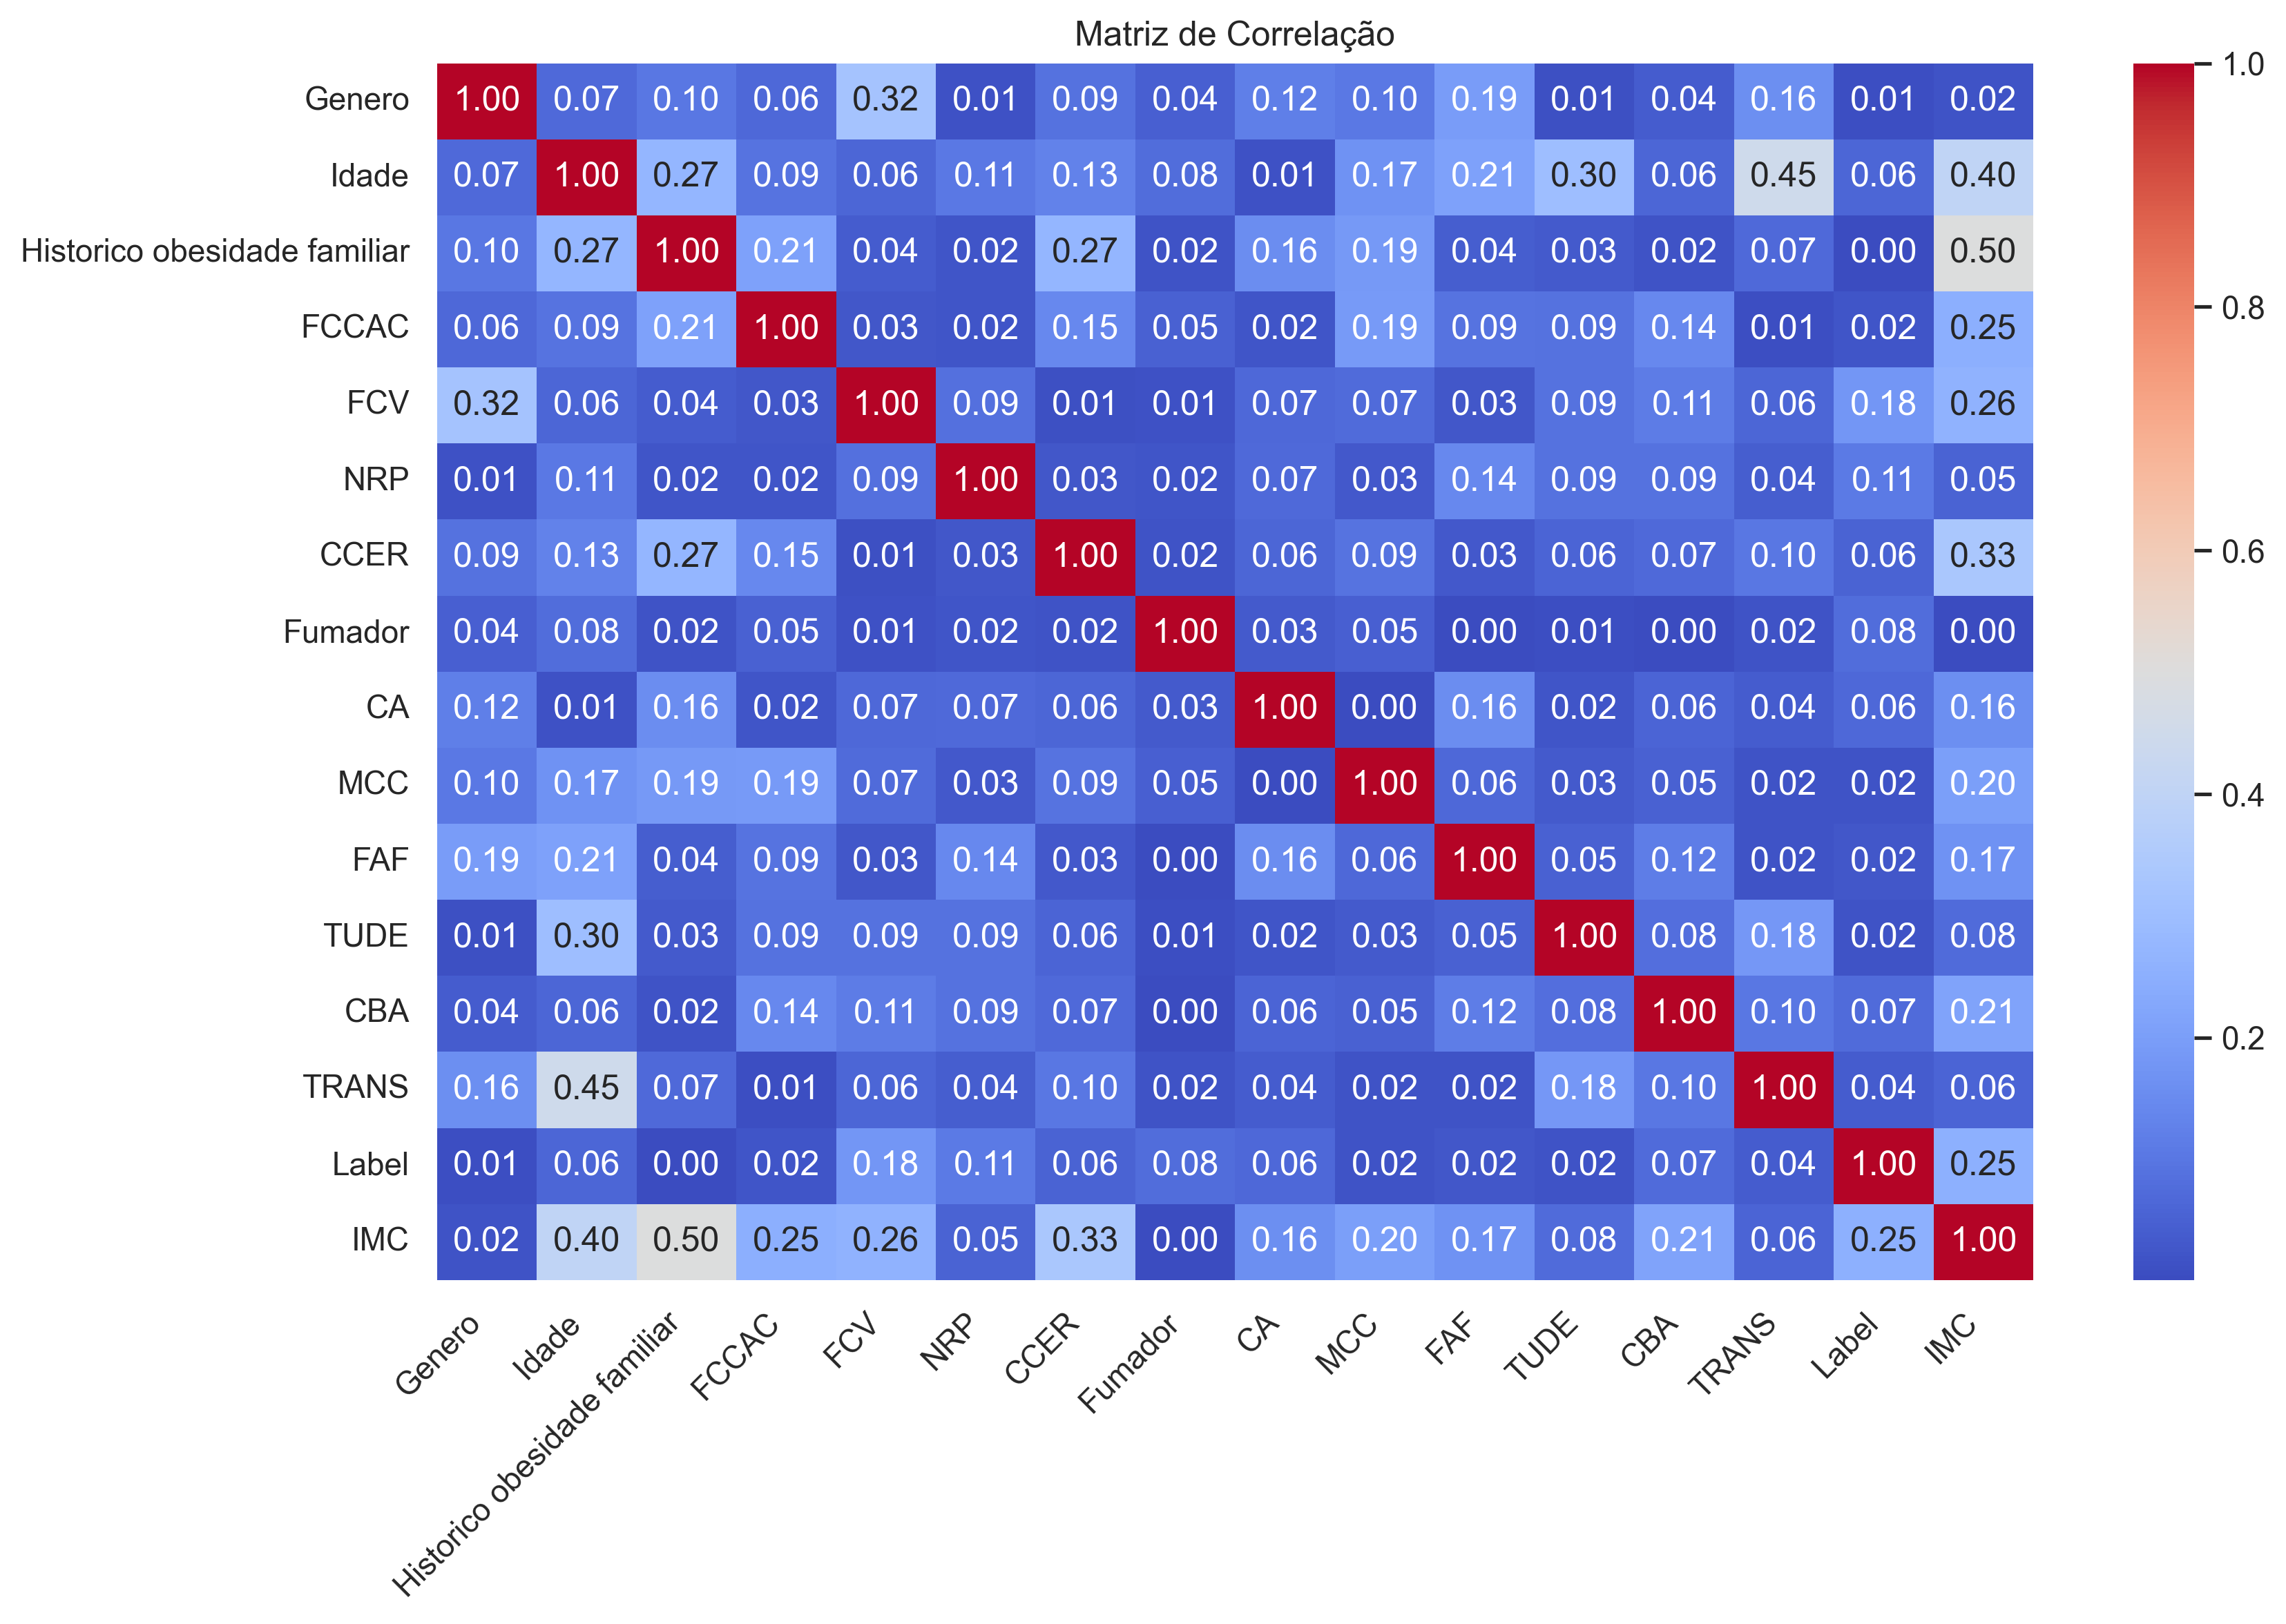

In [35]:
fig_corr = plt.figure(figsize=(12, 8))
etiquetas_corr = [undersplit(texto) for texto in dados_trabalho.columns]

for coluna in dados_trabalho.columns:
    dados_trabalho[coluna] = label_encoder.fit_transform(dados_trabalho[coluna].values)

sns.heatmap(dados_trabalho.corr(method="spearman").abs(), cmap='coolwarm', annot=True, fmt='.2f', mask=False)

plt.xticks(ticks=[i + 0.5 for i in range(len(dados_trabalho.columns))], labels=etiquetas_corr, rotation=45, ha='right')
plt.yticks(ticks=[i + 0.5 for i in range(len(dados_trabalho.columns))], labels=etiquetas_corr)
plt.title('Matriz de Correlação')
plt.tight_layout()

# plt.show()

Por este diagrama podemos ver que não existe uma forte correlação entre nenhum dos atributos. 

### 4.1.6

#### Hold-out

**Hold-out** é o processo de dividir um conjunto de dados em 2 sub-conjuntos de forma aleatória, um de maior dimensão que será utilizado para treinar um algoritmo de Machine Learning e o outra para o testar.


| Predictor | Target  |
|-----------|---------|
| Idade     | IMC     |

In [36]:
y = dados_trabalho.IMC
X = dados_trabalho[["Idade"]].to_numpy()

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, test_size=0.2, random_state=100)

#### Apresentar informação sobre os datasets de treino e aprendizagem

In [37]:
titulo("|\t\t\t\tDimensão\t\t\t|")
titulo("|   |\tTreino\t\t|\tTeste\t\t|")
texto(f"| X |\t{X_train.shape}\t|\t{X_test.shape}\t|")
texto(f"| y |\t{y_train.shape}\t\t|\t{y_test.shape}\t\t|")

|				Dimensão			|
|   |	Treino		|	Teste		|
| X |	(1688, 1)	|	(423, 1)	|
| y |	(1688,)		|	(423,)		|


#### Inicialização do algoritmo

In [38]:
regr_lin = LinearRegression()

#### Treinar o algoritmo

Para o treino utilizamos a função ``fit()``.

In [39]:
regr_lin.fit(X_train, y_train)

LinearRegression()

#### 4.1.6 a)

In [40]:
etiqueta_e_valor("Equação da reta:", f" y = {regr_lin.intercept_:.3f} + {regr_lin.coef_[0]:.3f} x")

Equação da reta::  y = 599.978 + 0.531 x


$$y = 0,355 + 0,381x$$

#### 4.1.6 b)

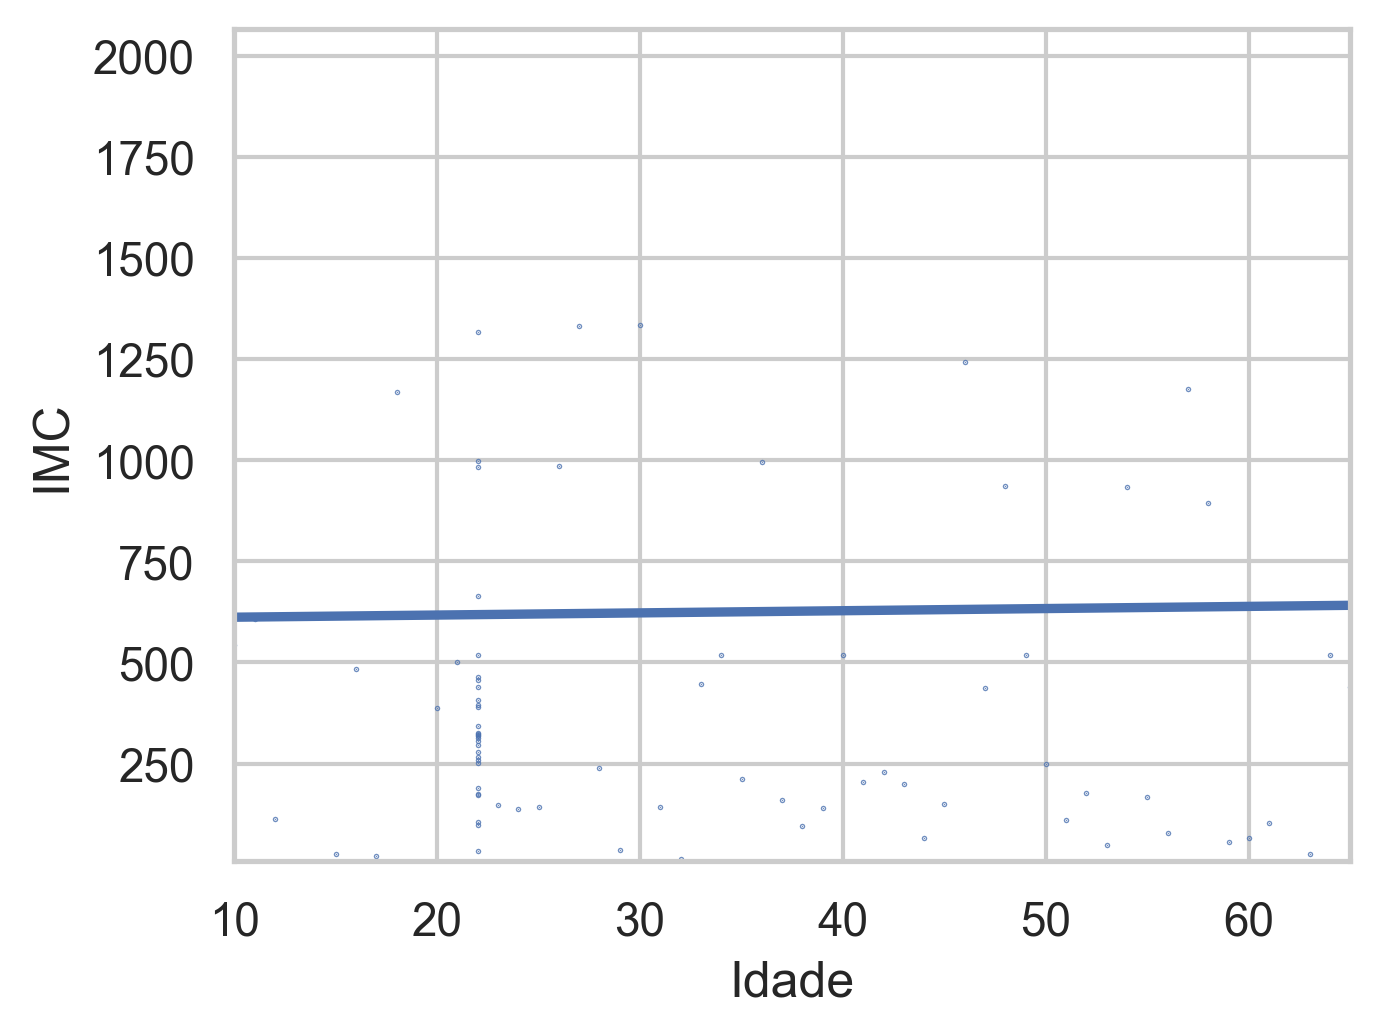

In [41]:
sns.regplot(x="Idade", y="IMC", data=dados_trabalho, order=1, ci=None, scatter_kws={"color": "b", "s": 0.1})
plt.xlim(10, 65)
plt.ylim(ymin=10);

Aplicar o modelo sobre o conjunto de teste.

In [42]:
y_pred = regr_lin.predict(X_test)

#### MAE

$$MAE = \sum_{i=1}^{D}|x_i-y_i|$$

In [43]:
MAE = np.mean(abs(y_test - y_pred))
etiqueta_e_valor("MAE no conjunto de dados de teste:", f"{MAE:.3f}")

MAE no conjunto de dados de teste:: 438.669


#### RMSE

$$RMSE = \sqrt{\frac{\sum_{i=0}^{N - 1} (y_i - \hat{y}_i)^2}{N}}$$

In [44]:
RMSE = np.sqrt(np.mean((y_test - y_pred) ** 2))
etiqueta_e_valor("RMSE no conjunto de dados de teste:", f"{RMSE:.3f}")

RMSE no conjunto de dados de teste:: 518.971


#### Repetir o cálculo mas com outros previsores (preditors)

O preditor vai mudando, podemos ter uma lista com o nome das colunas e fazer um ciclo que realiza os cálculos e guardamos o resultado num dicionário.

TODO: Utilizam-se os atributos base ou os antes do tratamento de dados.   

In [45]:
dados_slr = dados_trabalho.copy()

for coluna in dados_slr.columns:
    dados_slr[coluna] = label_encoder.fit_transform(dados_slr[coluna].values)


In [62]:
# O target não vai mudar.
y = dados_trabalho.IMC

# O preditor vai mudando, podemos ter uma lista com o nome das colunas
# lista_preditores = ['Genero', 'Historico_obesidade_familiar', 'FCCAC', 'FCV', 'NRP', 'CCER', 'Fumador', 'CA', 'MCC', 'FAF', 'TUDE', 'CBA', 'TRANS']

lista_preditores = dados_trabalho.columns

# Resultados
resultados = {}

for preditor in lista_preditores:
    X_preditor = dados_trabalho[[preditor]].to_numpy()
    X_train_1, X_test_1, y_train, y_test = train_test_split(X_preditor, y, train_size=0.8, test_size=0.2,
                                                            random_state=100)
    line_regr = LinearRegression()
    modelo = line_regr.fit(X_train_1, y_train)

    y_pred_1 = line_regr.predict(X_test_1)

    resultados[preditor] = {
        # "X_train": X_train_1,
        # "X_test": X_test_1,
        # "y_train": y_train,
        # "y_test": y_test,
        "modelo": modelo,
        "y_pred": y_pred_1,
        "MAE": np.mean(abs(y_test - y_pred_1)),
        "RMSE": np.sqrt(np.mean((y_test - y_pred_1) ** 2))
    }


#### Tabela com os resultados

Uma vez que temos o pandas, podemos utilizar este para apresentar a informação em formato de tabela.


TODO: Agora é preciso analisar os resultados e talvez produzir algum gráfico ou análise estatistica.

In [47]:
resultado = pd.DataFrame(resultados)

resultado.loc[["MAE", "RMSE"]]


Genero       Idade Historico_obesidade_familiar       FCCAC  \
MAE   486.566816  438.669429                   413.228915  470.367471   
RMSE   564.76211  518.970702                   497.533619  545.514614   

             FCV         NRP        CCER     Fumador          CA         MCC  \
MAE   471.562418  483.704651  438.353156  486.932539  481.379379  465.224997   
RMSE  545.884662  563.010375  523.423811  565.364024  561.609359  548.582965   

             FAF        TUDE         CBA       TRANS       Label  IMC  
MAE   481.365566  484.181302  482.870065  486.941622  422.255305  0.0  
RMSE  556.463949  562.571487  550.349374  564.178774  516.246058  0.0

### 4.1.7

#### a) Utilizar Regressão Linear Múltipla

| Target | Preditores |
|--------|------------|
| IMC    | ??         |

Ver TP5


Holdout



In [48]:
y = dados_trabalho.IMC
X = dados_trabalho[lista_preditores].to_numpy()

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, test_size=0.2,
                                                    random_state=100)

TODO: Imprimir a equação corretamente
TODO: Rever o código é cópia do TP5 

In [49]:
## Initialize algorithm
mlr = LinearRegression()

## Fit the data
mlr.fit(X_train, y_train)

print("Eq. da reta: y=", mlr.intercept_, "+", mlr.coef_, "x")

Eq. da reta: y= -1.1368683772161603e-12 + [ 8.68866027e-15  1.09634524e-15  1.31576782e-13  4.90457648e-14
  1.38777878e-17  2.82759927e-16  2.70045115e-14  1.13063589e-13
  8.70831185e-16 -7.78540245e-14  7.91033905e-16 -1.15836160e-15
 -6.88268226e-15  8.55507478e-14  2.84477345e-14  1.00000000e+00] x


In [50]:
#Prediction of test set
y_pred_mlr = mlr.predict(X_test)
#Predicted values
#print("Prediction for test set: {}".format(y_pred_mlr))

In [51]:
#Actual value and the predicted value
mlr_diff = pd.DataFrame({'Actual value': y_test, 'Predicted value': y_pred_mlr})
mlr_diff.head()

Actual value  Predicted value
785            501            501.0
1838          1957           1957.0
2083          1744           1744.0
1105           966            966.0
361           1258           1258.0

In [52]:
#Model Evaluation
from sklearn import metrics

meanAbErr = metrics.mean_absolute_error(y_test, y_pred_mlr)
meanSqErr = metrics.mean_squared_error(y_test, y_pred_mlr)

rootMeanSqErr = np.sqrt(metrics.mean_squared_error(y_test, y_pred_mlr))

print('R squared: {:.2f}'.format(mlr.score(X, y) * 100))
print('Mean Absolute Error:', meanAbErr)
print('Mean Square Error:', meanSqErr)
print('Root Mean Square Error:', rootMeanSqErr)

R squared: 100.00
Mean Absolute Error: 6.701925591847401e-13
Mean Square Error: 6.804145237475796e-25
Root Mean Square Error: 8.248724287716129e-13


#### b) DecisionTreeRegressor

Vamos usar os mesmos sets de treino e de teste.

TODO: Rever o código é cópia do TP5, ver TP7 tem uns testes que talvez sejam necessários.

In [53]:
arvore_decisao = DecisionTreeRegressor(
    random_state=42,
    max_depth=6,
    min_samples_split=3
)  # Restrição de alguns parâmetros da árvore
modelo_regressao = arvore_decisao.fit(X_train, y_train)

y_pred = arvore_decisao.predict(X_train)
y_pred1 = arvore_decisao.predict(X_test)

In [54]:
MAE1 = metrics.mean_absolute_error(y_train, y_pred)
MAE2 = metrics.mean_absolute_error(y_test, y_pred1)
MAE3 = np.mean(abs(y_test - y_pred1))  #efetuando os cálculos

print("MAE on training set: {:.3f}".format(MAE1))
print("MAE on test set: {:.3f}".format(MAE2))
print("MAE on test set: {:.3f}".format(MAE3))  #efetuando os cálculos

RMSE = np.sqrt(np.mean((y_test - y_pred1) ** 2))
print("RMSE: {:.4f}".format(RMSE))

MAE on training set: 7.479
MAE on test set: 8.382
MAE on test set: 8.382
RMSE: 9.6461


Visualização da Regression Tree

TODO: QUe valores utilizar?

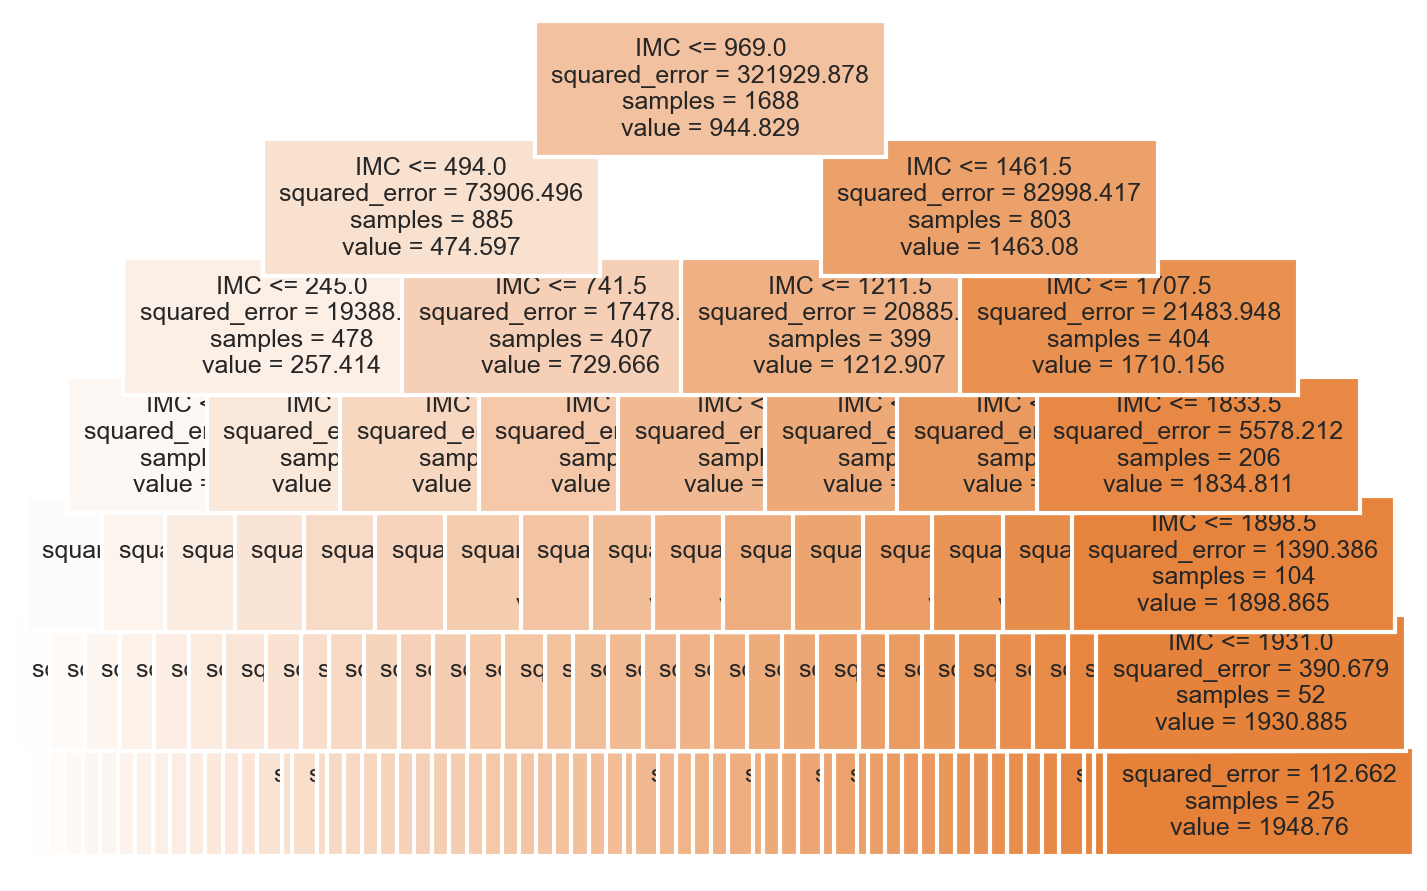

In [55]:
tree.plot_tree(
    modelo_regressao,
    feature_names=list(dados_trabalho.columns),
    class_names=list(dados_trabalho['IMC']),
    filled=True,
    fontsize=6
);

#### Modelo de regressão

In [56]:
print(export_text(modelo_regressao, show_weights=True))

|--- feature_15 <= 969.00
|   |--- feature_15 <= 494.00
|   |   |--- feature_15 <= 245.00
|   |   |   |--- feature_15 <= 126.00
|   |   |   |   |--- feature_15 <= 58.50
|   |   |   |   |   |--- feature_15 <= 30.50
|   |   |   |   |   |   |--- value: [14.89]
|   |   |   |   |   |--- feature_15 >  30.50
|   |   |   |   |   |   |--- value: [44.61]
|   |   |   |   |--- feature_15 >  58.50
|   |   |   |   |   |--- feature_15 <= 92.50
|   |   |   |   |   |   |--- value: [76.38]
|   |   |   |   |   |--- feature_15 >  92.50
|   |   |   |   |   |   |--- value: [108.79]
|   |   |   |--- feature_15 >  126.00
|   |   |   |   |--- feature_15 <= 185.50
|   |   |   |   |   |--- feature_15 <= 153.00
|   |   |   |   |   |   |--- value: [137.55]
|   |   |   |   |   |--- feature_15 >  153.00
|   |   |   |   |   |   |--- value: [169.46]
|   |   |   |   |--- feature_15 >  185.50
|   |   |   |   |   |--- feature_15 <= 215.00
|   |   |   |   |   |   |--- value: [200.56]
|   |   |   |   |   |--- feature_15 > 

#### c) MLPRegressor

TODO: Rever código é cópia do TP7

In [57]:
Nhidden = 1  # (?)

nn = MLPRegressor(hidden_layer_sizes=Nhidden,
                  activation='tanh',
                  solver='lbfgs', max_iter=1000, learning_rate_init=0.001)

In [58]:
nn.fit(X_train, y_train)

MLPRegressor(activation='tanh', hidden_layer_sizes=1, max_iter=1000,
             solver='lbfgs')

In [59]:
# Make prediction
pred = nn.predict(X_test)
#
# Calculate accuracy and error metrics
#
test_set_rsquared = nn.score(X_test, y_test)
test_set_rmse = np.sqrt(mean_squared_error(y_test, pred))
#
# Print R_squared and RMSE value
#
print('R_squared value: ', test_set_rsquared)
print('RMSE: ', test_set_rmse)

R_squared value:  -0.004202013901684065
RMSE:  565.3112172836336


In [60]:
print("weights between input and first hidden layer:")
print(nn.coefs_[0])
print("\nweights between first hidden and second hidden layer:")
print(nn.coefs_[1])

weights between input and first hidden layer:
[[  0.47441916]
 [ 52.53723239]
 [  0.45559141]
 [ -0.36214061]
 [ 18.58621254]
 [ 42.99694914]
 [  0.69135474]
 [ -0.53302083]
 [ 49.12418577]
 [  0.24887826]
 [ 59.30079264]
 [ 19.31953872]
 [  0.50729494]
 [  0.12312885]
 [  0.78347425]
 [104.33864805]]

weights between first hidden and second hidden layer:
[[468.24937684]]


### 4.1.8

TODO Realizar os cálculos do MAE e RMSE do 4.1.7 colunas num DataFrame e imprimir

In [61]:
comparar_417 = pd.DataFrame()
comparar_417

Empty DataFrame
Columns: []
Index: []

### 4.1.9

TODO: Estudo estatistico (ttest_ind) ? para os 2 modelos que apresentem melhores resultados.